# Plot frequency and anchoring information examples
Plot frequency and anchoring information for select NEs to motivate the problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
from datetime import datetime, timedelta

## Load data
Let's load the tagged NEs and extract (1) daily frequency, (2) weekly frequency and (3) daily context use.

In [2]:
anchor_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})

Compute daily frequency.

In [3]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import fix_timezone, round_to_day, assign_peak_date
## clean data
# fix bad usernames
anchor_data = anchor_data.assign(**{'username' : anchor_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})
# fix date timezone problem
date_var = 'date'
anchor_data = anchor_data.assign(**{date_var : anchor_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
## add rounded time var
round_date_var = '%s_day'%(date_var)
anchor_data = anchor_data.assign(**{round_date_var : anchor_data.loc[:, date_var].apply(lambda x: round_to_day(x, round_day=1))})
# also do weekly because daily data is too spiky
week_date_var = '%s_week'%(date_var)
anchor_data = anchor_data.assign(**{week_date_var : anchor_data.loc[:, date_var].apply(lambda x: round_to_day(x, round_day=7))})
# compute peak times per-NE
NE_var = 'NE_fixed'
round_date_var = 'date_day'
data_name_var = 'data_name_fixed'
NE_counts = anchor_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})
NE_week_counts = anchor_data.groupby([NE_var, data_name_var, week_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})

## limit to data with consistent NEs
# restrict to NEs that occur on at least k dates
# compute peaks
count_var = 'NE_count'
NE_count_peaks = NE_counts.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
anchor_data = pd.merge(anchor_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
NE_week_count_peaks = NE_week_counts.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=week_date_var)).reset_index().rename(columns={0 : 'peak_date'})
week_anchor_data = pd.merge(anchor_data, NE_week_count_peaks, on=[NE_var, data_name_var], how='inner')

In [4]:
from datetime import timedelta
data_name_var = 'data_name_fixed'
round_date_var = 'date_day'
def generate_date_range(data, inter_date_days=1):
    date_buffer_bins = int((data.max() - data.min()).days / inter_date_days)
    date_range = [data.min() + timedelta(days=(i*inter_date_days)) for i in range(date_buffer_bins+1)]
    return date_range
inter_date_days = 1
week_inter_date_days = 7
data_date_ranges = anchor_data.groupby(data_name_var).apply(lambda x: generate_date_range(x.loc[:, round_date_var], inter_date_days=inter_date_days))
week_data_date_ranges = week_anchor_data.groupby(data_name_var).apply(lambda x: generate_date_range(x.loc[:, week_date_var], inter_date_days=week_inter_date_days))

In [5]:
display(data_date_ranges)
display(week_data_date_ranges)

data_name_fixed
florence    [2018-09-03 00:00:00, 2018-09-04 00:00:00, 201...
harvey      [2017-08-19 00:00:00, 2017-08-20 00:00:00, 201...
irma        [2017-08-24 00:00:00, 2017-08-25 00:00:00, 201...
maria       [2017-08-29 00:00:00, 2017-08-30 00:00:00, 201...
michael     [2018-10-06 00:00:00, 2018-10-07 00:00:00, 201...
dtype: object

data_name_fixed
florence    [2018-09-02 00:00:00, 2018-09-09 00:00:00, 201...
harvey      [2017-08-19 00:00:00, 2017-08-26 00:00:00, 201...
irma        [2017-08-19 00:00:00, 2017-08-26 00:00:00, 201...
maria       [2017-08-26 00:00:00, 2017-09-02 00:00:00, 201...
michael     [2018-09-30 00:00:00, 2018-10-07 00:00:00, 201...
dtype: object

Add zero counts using date ranges.

In [6]:
NE_counts_date_ranges = pd.merge(NE_counts, data_date_ranges.reset_index().rename(columns={0 : 'data_range'}), on=data_name_var)
NE_week_counts_date_ranges = pd.merge(NE_week_counts, week_data_date_ranges.reset_index().rename(columns={0 : 'data_range'}), on=data_name_var)
display(NE_counts_date_ranges.head())
display(NE_week_counts_date_ranges.head())

NE_fixed data_name_fixed   date_day  NE_count  \
0  abbeville          harvey 2017-08-28         1   
1     abbott          harvey 2017-08-23         4   
2     abbott          harvey 2017-08-24         1   
3     abbott          harvey 2017-08-25        11   
4     abbott          harvey 2017-08-26         9   

                                          data_range  
0  [2017-08-19 00:00:00, 2017-08-20 00:00:00, 201...  
1  [2017-08-19 00:00:00, 2017-08-20 00:00:00, 201...  
2  [2017-08-19 00:00:00, 2017-08-20 00:00:00, 201...  
3  [2017-08-19 00:00:00, 2017-08-20 00:00:00, 201...  
4  [2017-08-19 00:00:00, 2017-08-20 00:00:00, 201...

NE_fixed data_name_fixed  date_week  NE_count  \
0  abbeville          harvey 2017-08-26         1   
1     abbott          harvey 2017-08-19        16   
2     abbott          harvey 2017-08-26        57   
3     abbott          harvey 2017-09-02         8   
4   aberdeen          harvey 2017-08-26         1   

                                          data_range  
0  [2017-08-19 00:00:00, 2017-08-26 00:00:00, 201...  
1  [2017-08-19 00:00:00, 2017-08-26 00:00:00, 201...  
2  [2017-08-19 00:00:00, 2017-08-26 00:00:00, 201...  
3  [2017-08-19 00:00:00, 2017-08-26 00:00:00, 201...  
4  [2017-08-19 00:00:00, 2017-08-26 00:00:00, 201...

In [7]:
date_range_var = 'data_range'
def add_zero_counts(counts_data, date_var='date_day'):
    NE_var = 'NE_fixed'
    data_name_var = 'data_name_fixed'
    date_range_var = 'data_range'
    counts_zeros = []
    for NE_i, data_i in counts_data.groupby([NE_var, data_name_var]):
        date_range_N = len(data_i.loc[:, date_range_var].values[0])
        data_i_zeros = pd.concat([pd.Series(np.repeat(data_i.loc[:, NE_var].iloc[0], date_range_N)),
                                  pd.Series(np.repeat(data_i.loc[:, data_name_var].iloc[0], date_range_N)),
                                  pd.Series(data_i.loc[:, date_range_var].values[0])], axis=1)
        data_i_zeros.columns = [NE_var, data_name_var, date_var]
        data_i = pd.merge(data_i, data_i_zeros, on=[NE_var, data_name_var, date_var], how='outer')
        data_i = data_i.drop(date_range_var, axis=1, inplace=False).fillna(0, inplace=False)
        counts_zeros.append(data_i)
    counts_zeros = pd.concat(counts_zeros, axis=0)
    return counts_zeros
NE_counts_zeros = add_zero_counts(NE_counts_date_ranges, date_var='date_day')
NE_week_counts_zeros = add_zero_counts(NE_week_counts_date_ranges, date_var='date_week')

Compute daily context use.

In [46]:
context_var = 'anchor'
context_pct_var = '%s_pct'%(context_var)
NE_context_pcts = anchor_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.loc[:, context_var].mean()).reset_index().rename(columns={0 : context_pct_var})
NE_week_context_pcts = week_anchor_data.groupby([NE_var, data_name_var, week_date_var]).apply(lambda x: x.loc[:, context_var].mean()).reset_index().rename(columns={0 : context_pct_var})
NE_context_pcts_date_ranges = pd.merge(NE_context_pcts, data_date_ranges.reset_index().rename(columns={0 : date_range_var}), on=data_name_var)
NE_week_context_pcts_date_ranges = pd.merge(NE_week_context_pcts, week_data_date_ranges.reset_index().rename(columns={0 : date_range_var}), on=data_name_var)

In [47]:
# NE_context_zeros = []
# for (NE_i, data_name_i), data_i in NE_context_pcts_date_ranges.groupby([NE_var, data_name_var]):
#     date_range_N = len(data_i.loc[:, date_range_var].values[0])
#     data_i_zeros = pd.concat([pd.Series(np.repeat(data_i.loc[:, NE_var].iloc[0], date_range_N)),
#                               pd.Series(np.repeat(data_i.loc[:, data_name_var].iloc[0], date_range_N)),
#                               pd.Series(data_i.loc[:, date_range_var].values[0])], axis=1)
#     data_i_zeros.columns = [NE_var, data_name_var, round_date_var]
#     data_i = pd.merge(data_i, data_i_zeros, on=[NE_var, data_name_var, round_date_var], how='outer')
#     data_i = data_i.drop(date_range_var, axis=1, inplace=False).fillna(0, inplace=False)
#     NE_context_zeros.append(data_i)
# NE_context_zeros = pd.concat(NE_context_zeros, axis=0) 
NE_context_zeros = add_zero_counts(NE_context_pcts_date_ranges, date_var=round_date_var)
NE_week_context_zeros = add_zero_counts(NE_week_context_pcts_date_ranges, date_var=week_date_var)

Compute mean counts per timestep.

In [10]:
# count_var = 'NE_count'
# count_mean_var = '%s_mean'%(count_var)
# NE_counts_per_time = NE_counts_zeros.groupby([NE_var, data_name_var]).apply(lambda x: x.loc[:, count_var].mean()).reset_index().rename(columns={0 : count_mean_var})
# display(NE_counts_per_time.head())

NE_fixed data_name_fixed  NE_count_mean
0         abbeville          harvey       0.037037
1         abbeville            irma       0.111111
2  abbeville county            irma       0.074074
3            abbott          harvey       3.000000
4            abbott            irma       0.037037

## Plot frequency and context over time
Let's look for an easy example of collective attention affecting context use.

processing florence data


/hg190/istewart6/miniconda3/envs/crisis_language_fixed/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/hg190/istewart6/miniconda3/envs/crisis_language_fixed/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


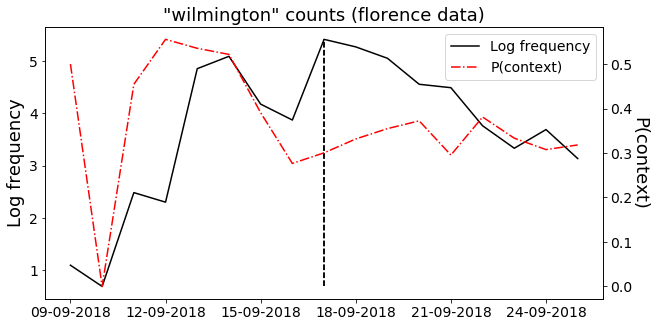

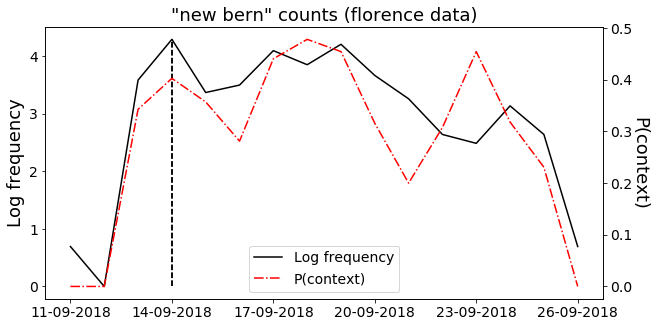

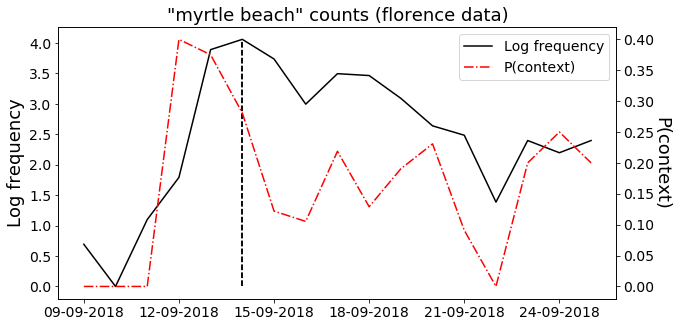

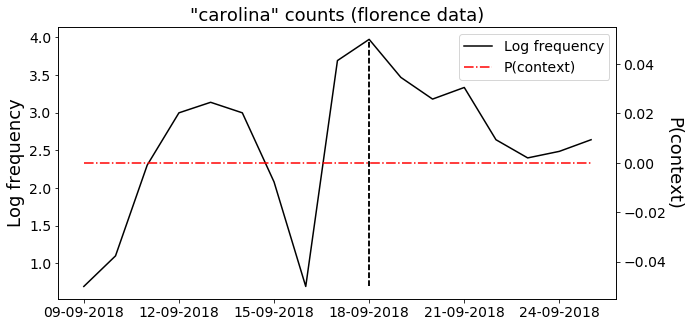

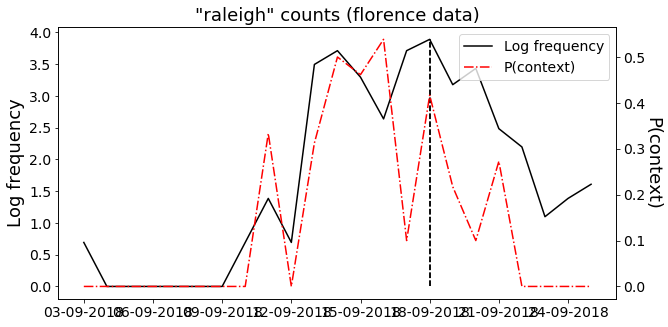

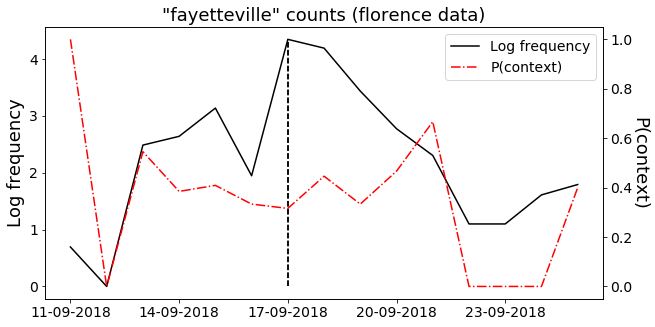

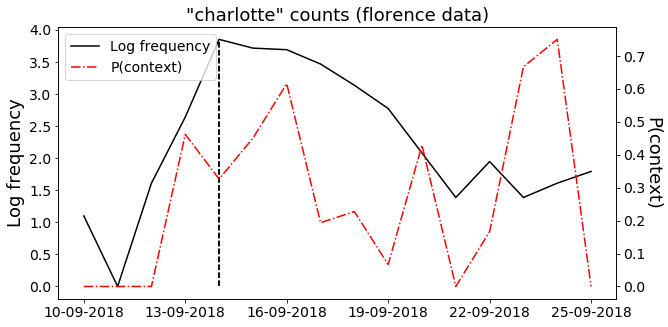

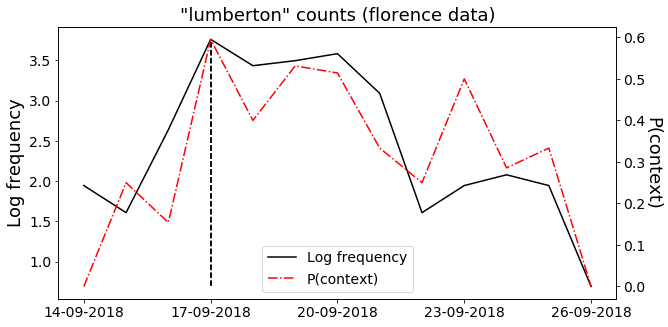

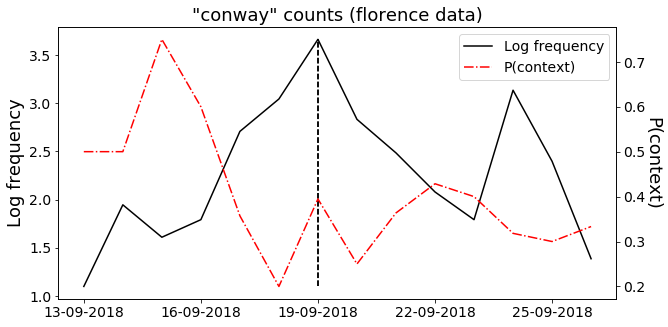

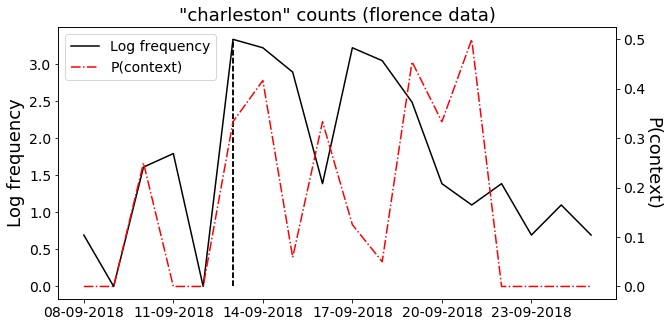

processing harvey data


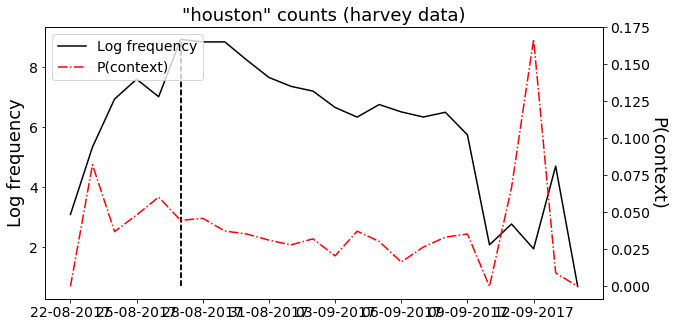

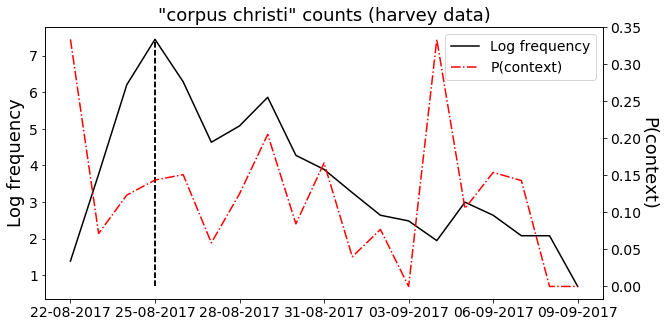

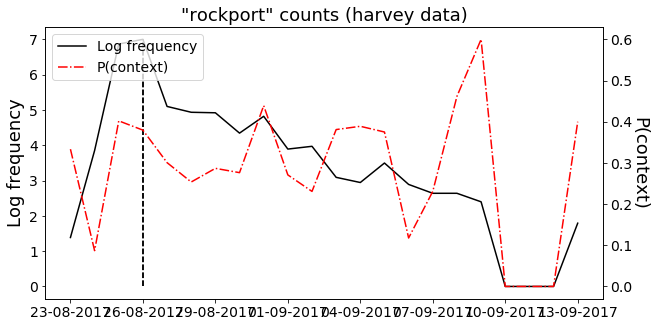

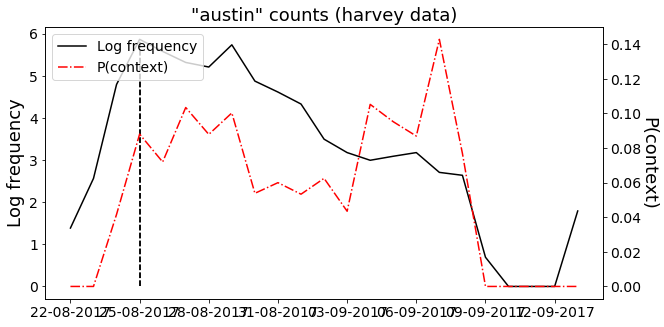

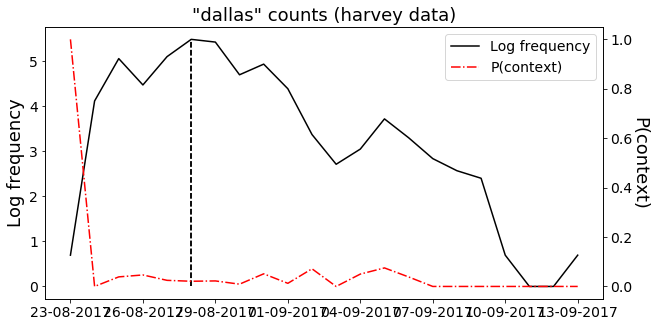

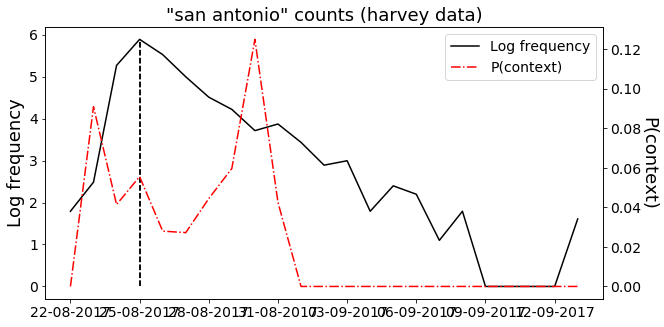

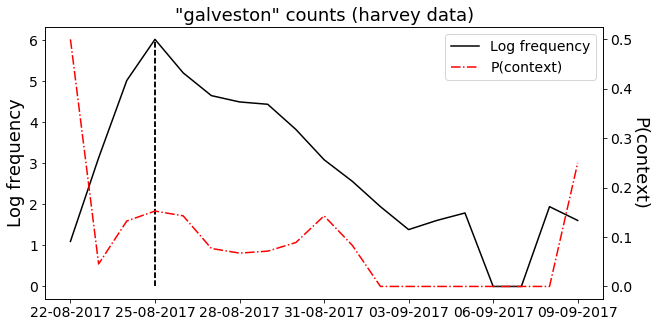

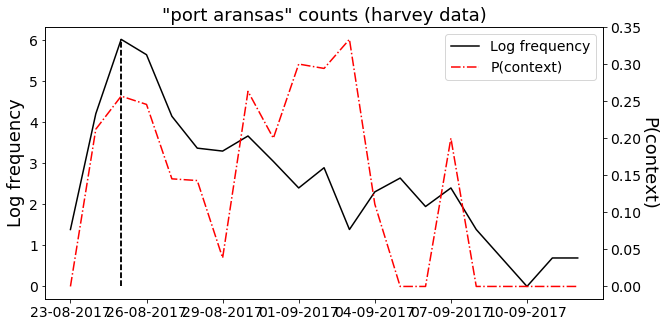

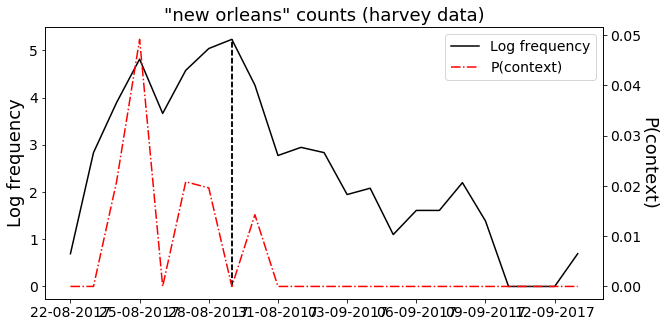

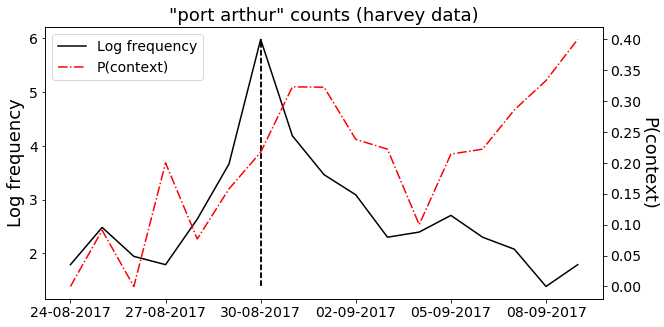

processing irma data


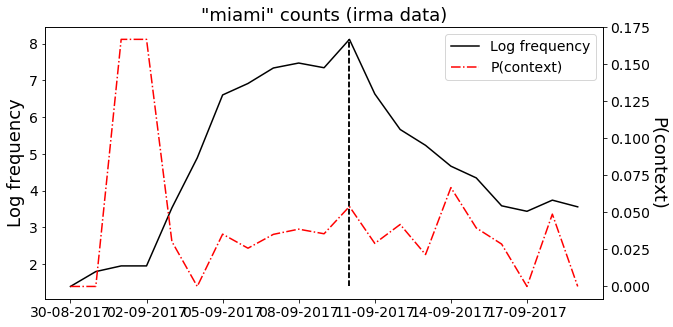

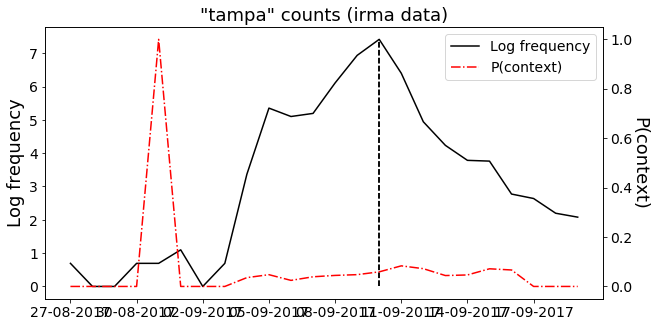

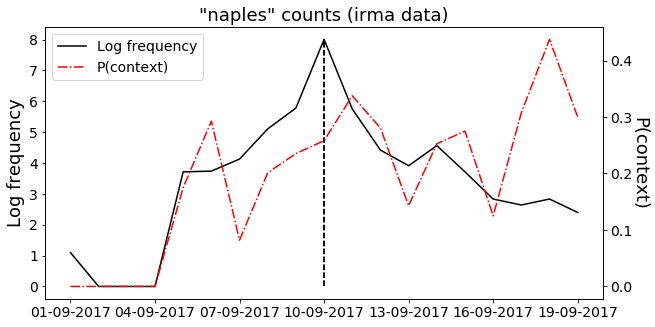

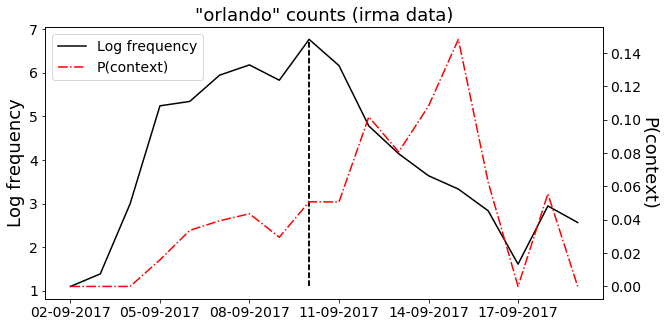

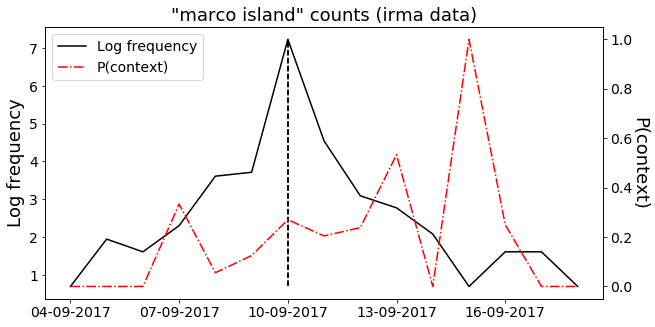

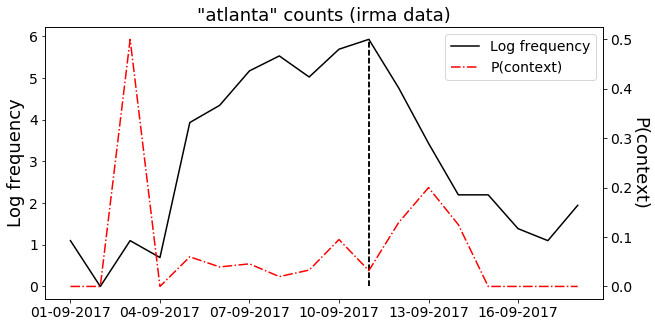

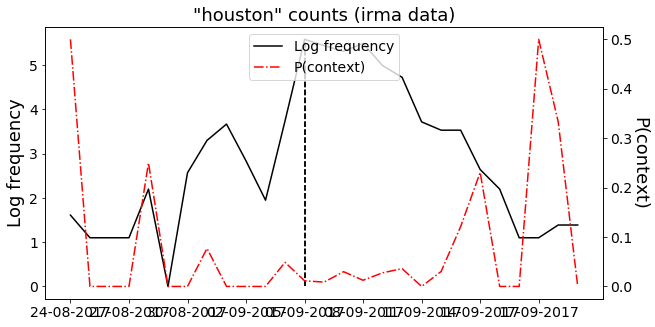

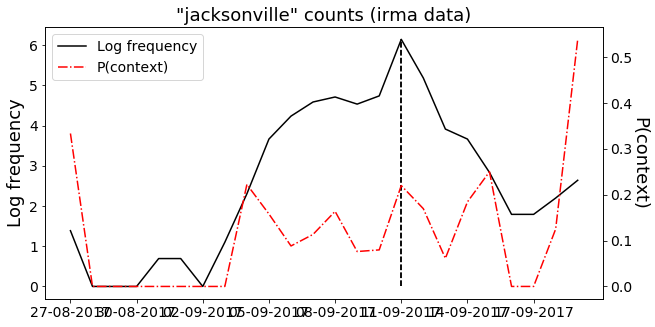

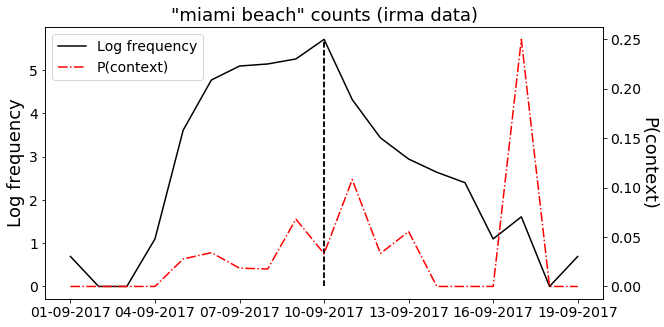

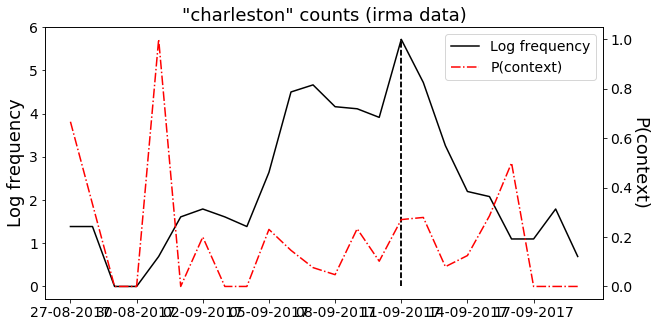

processing maria data


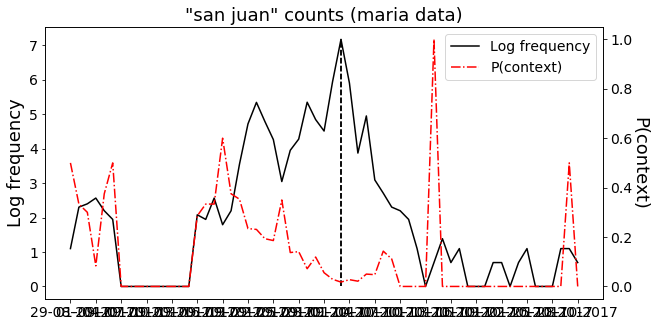

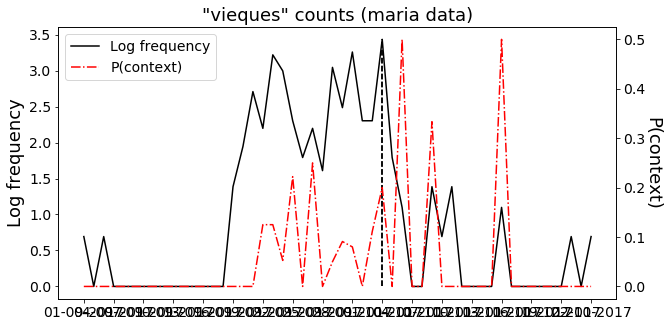

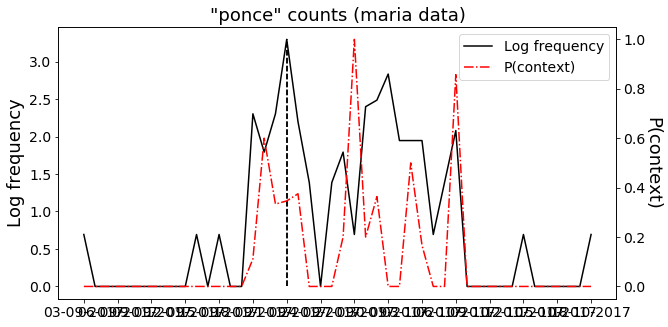

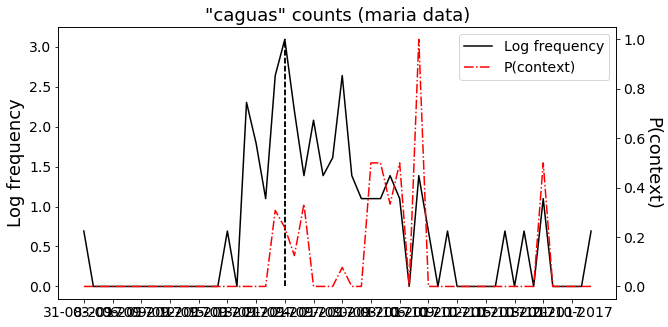

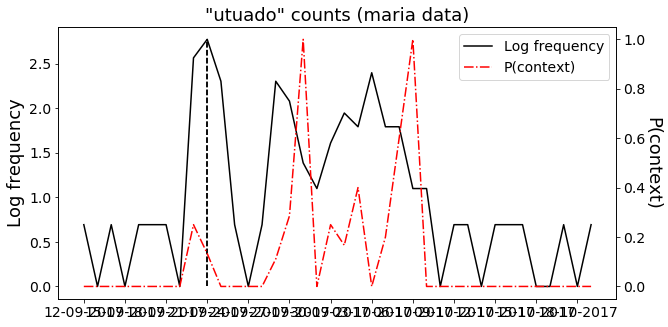

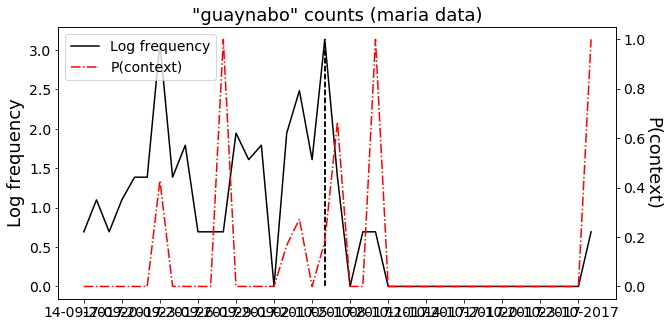

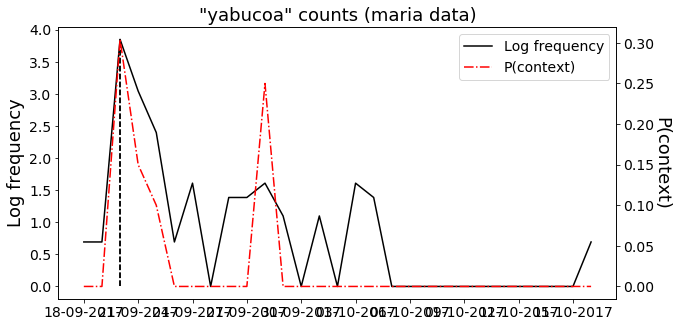

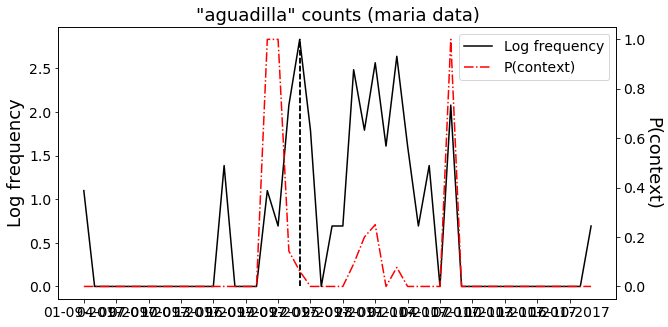

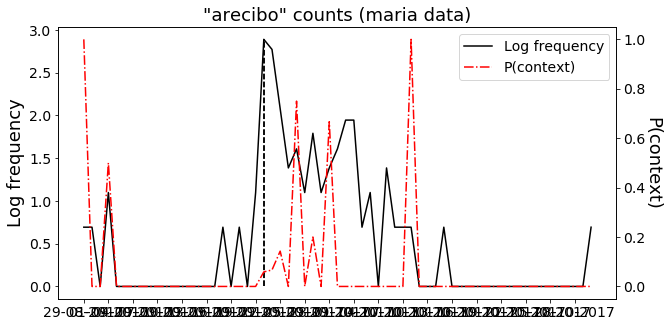

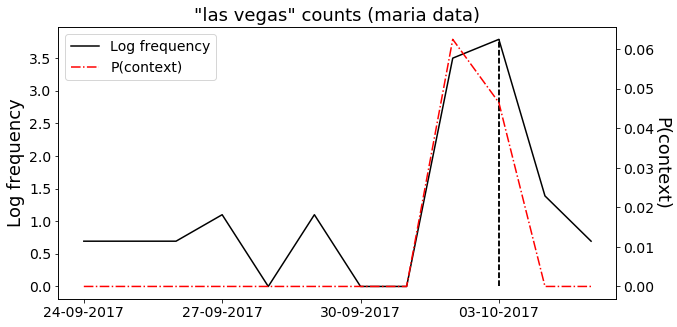

processing michael data


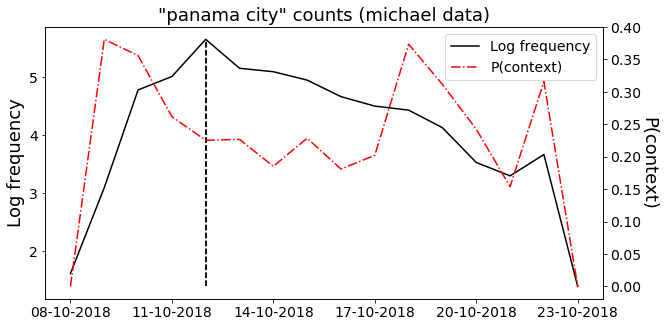

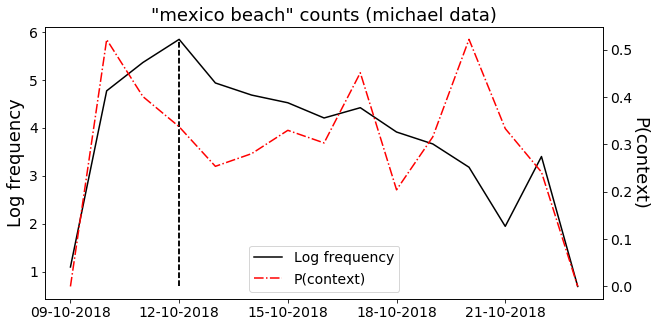

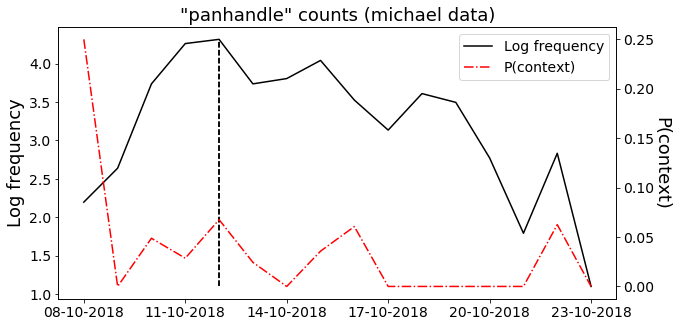

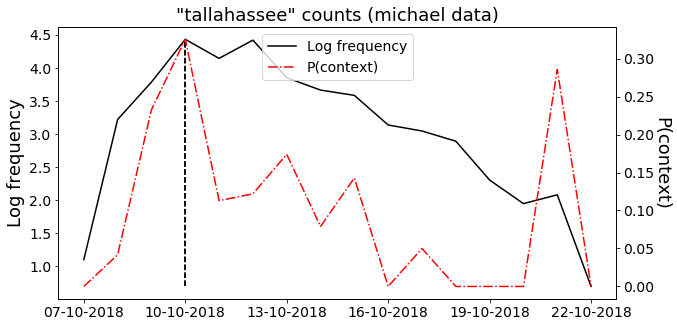

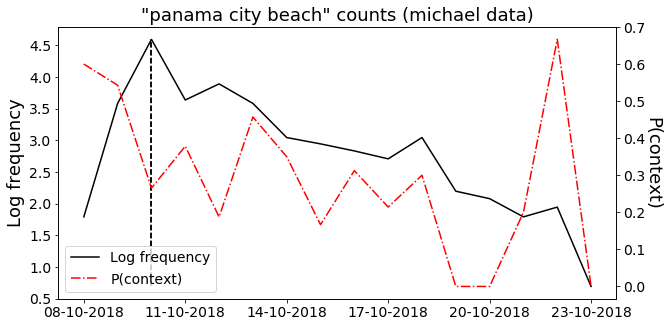

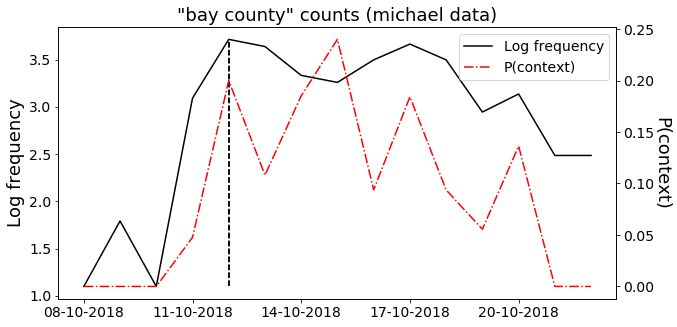

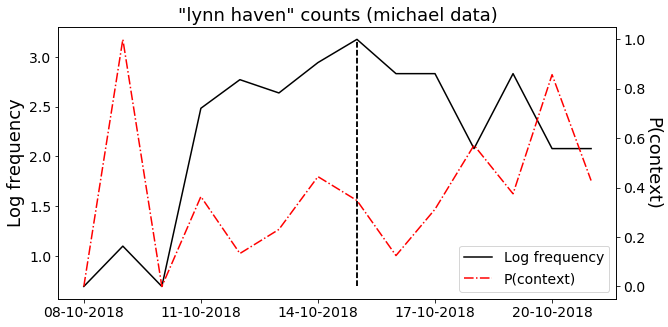

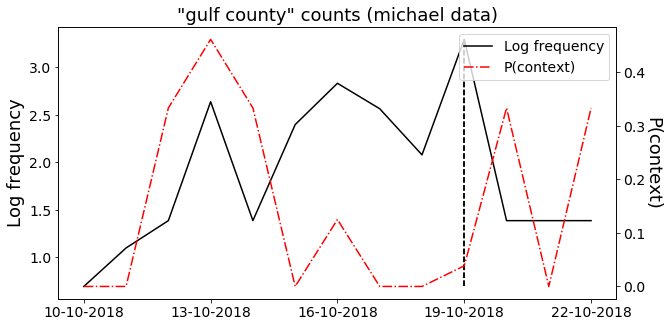

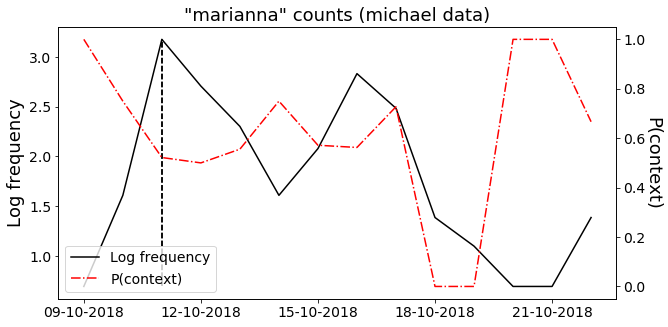

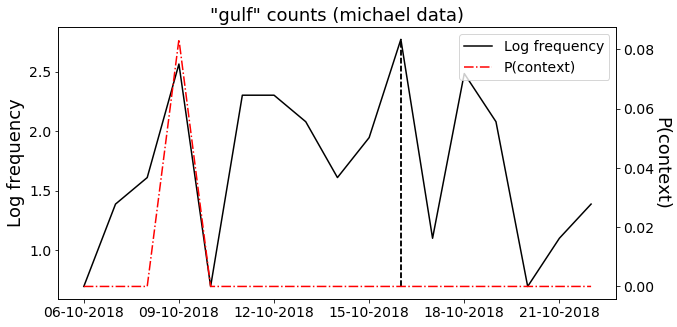

In [11]:
from datetime import datetime
top_k = 10
x_range_buffer_pct = 0.1
title_font_size = 18
label_font_size = 18
tick_font_size = 14
fig_height = 5
fig_width = 10
tick_date_fmt = '%d-%m-%Y'
for name_i, data_i in NE_counts_per_time.groupby(data_name_var):
    print('processing %s data'%(name_i))
    date_range_i = data_date_ranges.loc[name_i]
    x_range = [min(date_range_i), max(date_range_i)]
    x_lim_buffer = timedelta(days=((x_range[1]-x_range[0]).days * x_range_buffer_pct))
    x_lim = [min(date_range_i)-x_lim_buffer, max(date_range_i)+x_lim_buffer]
    counts_i = NE_counts_zeros[NE_counts_zeros.loc[:, data_name_var]==name_i].sort_values(round_date_var, inplace=False, ascending=True)
    context_pcts_i = NE_context_zeros[NE_context_zeros.loc[:, data_name_var]==name_i].sort_values(round_date_var, inplace=False, ascending=True)
    data_i.sort_values(count_mean_var, inplace=True, ascending=False)
    for j in range(top_k):
        NE_j = data_i.iloc[j].loc[NE_var]
        ## organize time, counts
        raw_counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
        # mark date with max frequency (for final plot)
        max_count_date_j = date_range_i[np.where(raw_counts_j==raw_counts_j.max())[0][0]]
        # limit x range to nonzero count dates
        min_date_j = date_range_i[min(np.where(raw_counts_j > 0.)[0])]
        max_date_j = date_range_i[max(np.where(raw_counts_j > 0.)[0])]
        # generate custom date range
        date_range_j = [min_date_j + timedelta(days=day_ctr) for day_ctr in range((max_date_j - min_date_j).days + 1)]
#         print(date_range_i)
#         print(date_range_j)
        # restrict counts to valid dates
        # raw counts
        counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
        # log counts
        counts_i_valid_dates = counts_i[(counts_i.loc[:, round_date_var] >= min_date_j) & 
                                        (counts_i.loc[:, round_date_var] <= max_date_j)]
        context_pcts_i_valid_dates = context_pcts_i[(context_pcts_i.loc[:, round_date_var] >= min_date_j) & 
                                                    (context_pcts_i.loc[:, round_date_var] <= max_date_j)]
        raw_counts_j_valid = counts_i_valid_dates[counts_i_valid_dates.loc[:, NE_var]==NE_j].loc[:, count_var]
        counts_j = np.log(raw_counts_j_valid+1)
        context_pcts_j = context_pcts_i_valid_dates[context_pcts_i_valid_dates.loc[:, NE_var]==NE_j].loc[:, context_pct_var]
#         x_lim = [min_date_j, max_date_j]
        
        ## plot
        f, ax1 = plt.subplots(figsize=(fig_width, fig_height))
        ax2 = ax1.twinx()
        # set axis tick sizes
        ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
        ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
        # raw counts
#         ax1.plot(date_range_i, counts_j, color='b')
        # log counts
        ax1_line = ax1.plot(date_range_j, counts_j, color='k', label='Log frequency')
        ax2_line = ax2.plot(date_range_j, context_pcts_j, color='r', linestyle='-.', label='P(context)')
        # vertical line for max frequency
        ax1.vlines(x=[max_count_date_j, max_count_date_j], ymin=counts_j.min(), ymax=counts_j.max(), linestyle='--', color='k')
        ax1.set_ylabel('Log frequency', fontsize=label_font_size)
        ax2.set_ylabel('P(context)', rotation=270, labelpad=16, fontsize=label_font_size)
#         ax1.set_ylim(counts_j.min() - ((counts_j.max() - counts_j.min())*0.1), 
#                      counts_j.max() + ((counts_j.max() - counts_j.min())*0.1))
#         ax2.set_ylim(context_pcts_j.min()-((context_pcts_j.max()-context_pcts_j.min())*0.1), 
#                      context_pcts_j.max()+((context_pcts_j.max()-context_pcts_j.min())*0.1))
        plt.title('"%s" counts (%s data)'%(NE_j, name_i), fontsize=title_font_size)
#         plt.xlim(*x_lim)
        # add legend
        # single axis
#         plt.legend(loc='upper right')
        # multiple axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1+lines2, labels1+labels2, fontsize=tick_font_size)
        # set x-ticks so they actually fit ;_;
        x_ticks = date_range_j[::3]
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels([date_k.strftime(tick_date_fmt) for date_k in x_ticks])
#         x_ticks = ax1.get_xticks()
#         x_tick_labels = [x_tick.get_text() for x_tick in ax1.get_xticklabels()]
#         x_ticks, x_tick_labels = zip(*list(zip(x_ticks, x_tick_labels))[::2])
#         print(x_ticks)
#         print(x_tick_labels)
#         print(ax2.get_xticks())
#         ax1.set_xticks(x_ticks)
#         ax1.set_xticklabels(x_tick_labels)
        plt.show()

Let's make a custom plot for `San Juan` including example context/non-context posts.

In [25]:
# find examples of NE with/without descriptor
NEs_to_test = ['san juan', 'myrtle beach']
crisis_names_to_test = ['maria', 'florence']
for NE_j, name_i in zip(NEs_to_test, crisis_names_to_test):
    print('*~*~*~*~*~*~')
    print('testing NE=%s in data=%s'%(NE_j, name_i))
# name_i = 'maria'
# NE_j = 'san juan'
    data_i_j = anchor_data[(anchor_data.loc[:, data_name_var]==name_i) &
                           (anchor_data.loc[:, NE_var]==NE_j)]
    # get split date => max frequency date
    counts_i = NE_counts_zeros[NE_counts_zeros.loc[:, data_name_var]==name_i].sort_values(round_date_var, inplace=False, ascending=True)
    date_range_i = data_date_ranges.loc[name_i]
    raw_counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
    max_count_date_j = date_range_i[np.where(raw_counts_j==raw_counts_j.max())[0][0]]
    context_var = 'anchor'
    txt_var = 'txt'
    # print text
#     display(data_i_j[(data_i_j.loc[:, round_date_var] < max_count_date_j) & 
#                      (data_i_j.loc[:, context_var]==1)].loc[:, txt_var].head(30).values)
#     display(data_i_j[(data_i_j.loc[:, round_date_var] > max_count_date_j) & 
#                      (data_i_j.loc[:, context_var]==0)].loc[:, txt_var].head(30).values)
    # print text and date => needed for timelines
    display(data_i_j[(data_i_j.loc[:, round_date_var] < max_count_date_j) & 
                     (data_i_j.loc[:, context_var]==1)].loc[:, [txt_var, round_date_var]].head(100).values)
    display(data_i_j[(data_i_j.loc[:, round_date_var] > max_count_date_j) & 
                     (data_i_j.loc[:, context_var]==0)].loc[:, [txt_var, round_date_var]].head(1000).tail(100).values)

*~*~*~*~*~*~
testing NE=san juan in data=maria


array([['Cheap #flights to San Juan, Puerto Rico - Compare these prices & Save! <URL>',
        Timestamp('2017-08-29 00:00:00')],
       ['In San Juan, PR Partly Cloudy today! With a high of 90F and a low of 79F. #PuertoRico #SanJuan #Beach',
        Timestamp('2017-08-30 00:00:00')],
       ['In San Juan, PR Partly Cloudy today! With a high of 88F and a low of 79F. #PuertoRico #SanJuan #Beach',
        Timestamp('2017-08-30 00:00:00')],
       ['Great Deals on #Hotels & Vacations in San Juan, Puerto Rico! Book Now & Save... <URL>',
        Timestamp('2017-08-30 00:00:00')],
       ['In San Juan, PR Partly Cloudy today! With a high of 91F and a low of 79F. #PuertoRico #SanJuan #Beach',
        Timestamp('2017-08-31 00:00:00')],
       ['In San Juan, PR Partly Cloudy today! With a high of 89F and a low of 79F. #PuertoRico #SanJuan #Beach',
        Timestamp('2017-08-31 00:00:00')],
       ['Exploring Old San Juan in Puerto Rico! #AdelekeApproved #PuertoRico #LaborDayWeekend @El… <URL>'

array([['@realDonaldTrump is in San Juan/Ft. Buchanan area the rest is decimated. @MSNBC @CNN #hurricanemaria #puertorico #propaganda',
        Timestamp('2017-10-03 00:00:00')],
       ['RT CustomsBorder: Working hard for you #PuertoRico . OFO officers remove debris from an orphanage near San Juan. #H … <URL>',
        Timestamp('2017-10-03 00:00:00')],
       ["Pres #Trump Conducts #Meeting in #PuertoRico . Ignores San Juan's Mayor. <URL>",
        Timestamp('2017-10-03 00:00:00')],
       ['So where is the character and Charisma and leadership of the mayor of San Juan @realDonaldTrump #PuertoRico',
        Timestamp('2017-10-03 00:00:00')],
       ["Trump busy wondering what its gonna take to remove Governor's @Ricardorossello head from Trump's rectum~ San Juan #PuertoRico",
        Timestamp('2017-10-03 00:00:00')],
       ['RT @CustomsBorder: Working hard for you #PuertoRico. OFO officers remove debris from an orphanage near San Juan. #HurricaneMaria. <URL>',
        Timestamp('20

*~*~*~*~*~*~
testing NE=myrtle beach in data=florence


array([['RT @Ryan11Alive: As #HurricaneFlorence shifts so do we. We’re now on our way to Myrtle Beach, SC. #11Alive #Storm11 <URL>',
        Timestamp('2018-09-12 00:00:00')],
       ['RT @JackieLayerOn7: 2PM Update: 435 miles SE of Wilmington, NC &amp; 470 miles ESE of Myrtle Beach, SC, #Florence now a high-end Cat. 3 storm,…',
        Timestamp('2018-09-12 00:00:00')],
       ['Lots of prayers & so much love goes out to one of my favorite getaway places- & to the rest of the Carolinas. 💛#hurricaneflorencebekind @ Myrtle Beach, South Carolina <URL>',
        Timestamp('2018-09-13 00:00:00')],
       ["Well it's up time.  420..... Haha..  #hurricaneflorence I'm still gone tough it out. #420lifestyle #smokingweed @ Myrtle Beach, South Carolina <URL>",
        Timestamp('2018-09-13 00:00:00')],
       ['The hospital in Myrtle Beach, SC, has been fully evacuated ahead of #HurricaneFlorence. Hundreds of patients have been transported to other facilities in Georgia and Florida: Mayor',
    

array([['#HurricaneFlorence video: Waterspout comes ashore, becomes tornado in Myrtle Beach: <URL>',
        Timestamp('2018-09-17 00:00:00')],
       ["@HorryDemocrats are looking forward to @MichaelAvenatti keynote at our fundraiser October 13 in Myrtle Beach. We're eager to do our part to turn SC blue, but first we've got a little clean up #HurricaneFlorence #MyrtleBeach #HorryCounty <URL>",
        Timestamp('2018-09-17 00:00:00')],
       ['Large water spout forms off Myrtle Beach. <URL>',
        Timestamp('2018-09-17 00:00:00')],
       ['I can only cry tears of joy for #HurricaneFlorence missing Myrtle Beach. Prayers for everyone in her path. Prayers for everyone affected by Florence',
        Timestamp('2018-09-17 00:00:00')],
       ['#HurricaneFlorence : #Waterspout forms off Myrtle Beach shore prompting tornado warning: Independent <URL>',
        Timestamp('2018-09-17 00:00:00')],
       ['Well, things do *not* appear to be going well along the US 501 N/S between Myrtle Be

In [34]:
pre_peak_txt_all = [
    [
        '3 tropical systems currently. On my way to San Juan, PR to cover #Maria', 
        'Busy week coming up, so just trying to get ahead. This will be Tues a.m. in San Juan, Puerto Rico. #Maria'
    ],
    [
        'As #HurricaneFlorence shifts so do we. We’re now on our way to Myrtle Beach, SC.',
        'The hospital in Myrtle Beach, SC, has been fully evacuated ahead of #HurricaneFlorence.'
    ]                   
]

post_peak_txt_all = [
    [
        'Frantic at San Francisco Hospital near San Juan where generators have failed',
        '#Maria . Please. Can someone tell me how is Sabana Grande? And roads from San Juan.',
    ],
    [
        
        'WOW: This is the scene right now at Second Avenue Pier in Myrtle Beach. #HurricaneFlorence',
        "If you'd like to help #Florence flood victims in Myrtle Beach and the surrounding areas, here's one way to donate."
    ]                   
]

pre_peak_dates_all = [
    [
        '2017-09-18',
        '2017-09-17',
    ],
    [
        '2018-09-12',
        '2018-09-13',
    ]
]

post_peak_dates_all = [
    [
        '2017-10-01',
        '2017-10-04',
    ],
    [
        '2018-09-15',
        '2018-09-20',
    ]
]

### Plot frequency, descriptor probability, timeline

Plot frequency, descriptor probability and dots on timeline to indicate text box locations.

In [69]:
from dateutil import parser as date_parser
from math import ceil, floor
import matplotlib


def get_ylim_lower(ylim, buffer_pct):
    ylim_lower =  ylim[0]-(ylim[1]-ylim[0])*buffer_pct
    return ylim_lower
## set up text values
## update: doing it manually because plotting is hard, let's go shopping
# def word_wrap(txt, word_wrap_len=3):
#     txt_tokens = txt.split(' ')
#     chunks = int(ceil(len(txt_tokens) / word_wrap_len))
#     txt_wrap = '\n'.join([' '.join(txt_tokens[(chunk*word_wrap_len):((chunk+1)*word_wrap_len)]) for chunk in range(chunks)])
#     return txt_wrap
# word_wrap_len = 3
# pre_peak_txt = '3 tropical systems currently. On my way to San Juan, PR to cover #Maria'
# post_peak_txt = 'Frantic at San Francisco Hospital near San Juan where generators have failed'
# pre_peak_txt = 'Exploring Old\n San Juan in\n Puerto Rico!'
# post_peak_txt = "Hoping to get\n it out Monday\n to a friend's\n family in San Juan."
# pre_peak_txt =  word_wrap(pre_peak_txt, word_wrap_len=word_wrap_len)
# post_peak_txt =  word_wrap(post_peak_txt, word_wrap_len=word_wrap_len)
def plot_data(data_names_to_plot, NEs_to_plot, pre_peak_dates_all, post_peak_dates_all, count_data, context_data, data_date_ranges, date_var='date_day', days_per_timestep=1):
    NE_var = 'NE_fixed'
    count_var = 'NE_count'
    context_pct_var = 'anchor_pct'
    # plot params
    x_range_buffer_pct = 0.1
    title_font_size = 18
    label_font_size = 18
    tick_font_size = 14
    fig_height = 5
    fig_width = 10
    tick_date_fmt = '%d-%m-%Y'
    dates_per_plot = 6
    X_AXIS_BUFFER_PCT = 0.025

    for idx, (name_i, NE_j) in enumerate(zip(data_names_to_plot, NEs_to_plot)):
    ## get count/context data
        date_range_i = data_date_ranges.loc[name_i]
#         print('date range %s'%(date_range_i))
        x_range = [min(date_range_i), max(date_range_i)]
        x_lim_buffer = timedelta(days=((x_range[1]-x_range[0]).days * x_range_buffer_pct))
        x_lim = [min(date_range_i)-x_lim_buffer, max(date_range_i)+x_lim_buffer]
        counts_i = count_data[count_data.loc[:, data_name_var]==name_i].sort_values(date_var, inplace=False, ascending=True)
        context_pcts_i = context_data[context_data.loc[:, data_name_var]==name_i].sort_values(date_var, inplace=False, ascending=True)

        ## organize time, counts
        raw_counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
#         print('raw counts %s'%(raw_counts_j))
        # mark date with max frequency (for final plot)
        max_count_date_j = date_range_i[np.where(raw_counts_j==raw_counts_j.max())[0][0]]
        # limit x range to nonzero count dates
        min_date_j = date_range_i[min(np.where(raw_counts_j > 0.)[0])]
        max_date_j = date_range_i[max(np.where(raw_counts_j > 0.)[0])]
        # generate custom date range
        time_step_count = int(floor((max_date_j - min_date_j).days / days_per_timestep))
        date_range_j = [min_date_j + timedelta(days=k*days_per_timestep) for k in range(time_step_count + 1)]
        # restrict counts to valid dates
        # raw counts
        counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
        # log counts
        counts_i_valid_dates = counts_i[(counts_i.loc[:, date_var] >= min_date_j) & 
                                        (counts_i.loc[:, date_var] <= max_date_j)]
        context_pcts_i_valid_dates = context_pcts_i[(context_pcts_i.loc[:, date_var] >= min_date_j) & 
                                                    (context_pcts_i.loc[:, date_var] <= max_date_j)]
        raw_counts_j_valid = counts_i_valid_dates[counts_i_valid_dates.loc[:, NE_var]==NE_j].loc[:, count_var]
        counts_j = np.log(raw_counts_j_valid+1)
        context_pcts_j = context_pcts_i_valid_dates[context_pcts_i_valid_dates.loc[:, NE_var]==NE_j].loc[:, context_pct_var]

        ## plot
        fig_height = 5
        fig_width = 12
        f, ax1 = plt.subplots(figsize=(fig_width, fig_height))
        ax2 = ax1.twinx()
        # set axis tick sizes
        ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
        ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
        # log counts
        ax1_line = ax1.plot(date_range_j, counts_j, color='k', label='Log frequency')
        ax2_line = ax2.plot(date_range_j, context_pcts_j, color='r', linestyle='-.', label='P(descriptor)')
        # vertical line for peak date
#         ax1.vlines(x=[max_count_date_j, max_count_date_j], ymin=counts_j.min(), ymax=counts_j.max(), linestyle='--', color='k') # line from min to max value
        plt.axvline(x=max_count_date_j, linestyle='--', color='k') # line from bottom to top of plot
        ax1.set_ylabel('Log frequency', fontsize=label_font_size)
        ax2.set_ylabel('P(descriptor)', rotation=270, labelpad=18, fontsize=label_font_size)
        plt.title('"%s" time series'%(NE_j), fontsize=title_font_size)

        ## set legend, ticks for multiple axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1+lines2, labels1+labels2, fontsize=tick_font_size)
        # add timeline
#         ax2.hlines(y=[min(context_pcts_j), min(context_pcts_j)], xmin=date_range_j[0], xmax=date_range_j[-1])
#         ax2.hlines(y=[min(context_pcts_j), min(context_pcts_j)], xmin=date_range_j[0], xmax=date_range_j[-1])
        plt.axhline(y=min(context_pcts_j), color='k')
        # set x-ticks so they actually fit ;_;
        date_chunks = int(len(date_range_j) / dates_per_plot)
#         print('%d date range %d date chunks'%(len(date_range_j), date_chunks))
        x_ticks = date_range_j[::(date_chunks+1)]
        ax1.set_xticks(x_ticks)
#         ax1.set_xticklabels([date_k.strftime(tick_date_fmt) for date_k in x_ticks], rotation=45) # rotated ticks
        ax1.set_xticklabels([date_k.strftime(tick_date_fmt) for date_k in x_ticks], size=12) # small ticks
        # set y axis limits
#         ax1.set_ylim((counts_j.min(), counts_j.max()))
#         ax2.set_ylim((context_pcts_j.min(), context_pcts_j.max()))

        ## align y axes

        ylim_1 = ax1.get_ylim()
        ylim_2 = ax2.get_ylim()
        ax1.set_ylim([get_ylim_lower(ylim_1, X_AXIS_BUFFER_PCT), ylim_1[1]])
        ax2.set_ylim([get_ylim_lower(ylim_2, X_AXIS_BUFFER_PCT), ylim_2[1]])
#         ylim_1 = ax1.get_ylim()
#         ylim_2 = ax2.get_ylim()
#         def get_tick_diffs(x, ylim_1, ylim_2):
#             tick_diffs = ylim_2[0]+(x-ylim_1[0])/(ylim_1[1]-ylim_1[0])*(ylim_2[1]-ylim_2[0])
#             return tick_diffs
#         ticks = get_tick_diffs(ax1.get_yticks(), ylim_1, ylim_2)
#         ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))


        ## add text
        # date_range_j_count = len(date_range_j)
        # pre_text_x = date_range_j[int(date_range_j_count * (1/16.))]
        # post_text_x = date_range_j[int(date_range_j_count * (3/4.))]
        # text_y = (counts_j.max() - counts_j.min()) / 2.
        # ax1.text(pre_text_x, text_y, pre_peak_txt, bbox={'alpha':0.5}, fontsize=tick_font_size)
        # ax1.text(post_text_x, text_y, post_peak_txt, bbox={'alpha':0.5}, fontsize=tick_font_size)

        ## add dots for text boxes
        pre_peak_dates_i = list(map(date_parser.parse, pre_peak_dates_all[idx]))
        post_peak_dates_i = list(map(date_parser.parse, post_peak_dates_all[idx]))

        ax2.scatter(pre_peak_dates_i, [0,]*len(pre_peak_dates_i), color='k')
        ax2.scatter(post_peak_dates_i, [0,]*len(post_peak_dates_i), color='k')

        plt.show()

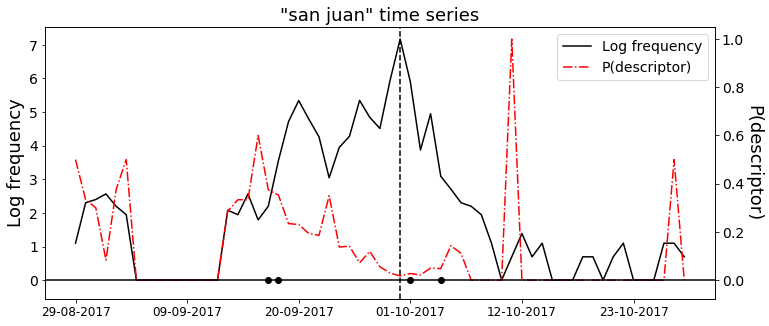

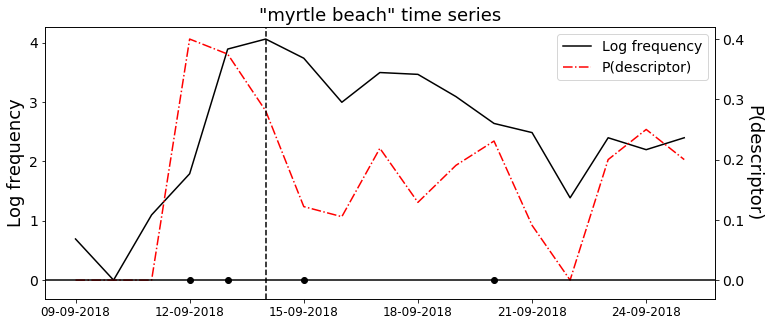

In [75]:
# daily
data_names_to_plot = ['maria', 'florence']
NEs_to_plot = ['san juan', 'myrtle beach']
days_per_timestep = 1
plot_data(data_names_to_plot, NEs_to_plot, pre_peak_dates_all, post_peak_dates_all, NE_counts_zeros, NE_context_zeros, data_date_ranges, date_var=round_date_var, days_per_timestep=days_per_timestep)

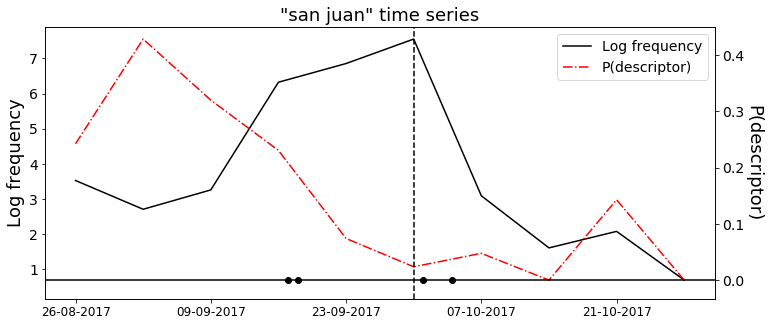

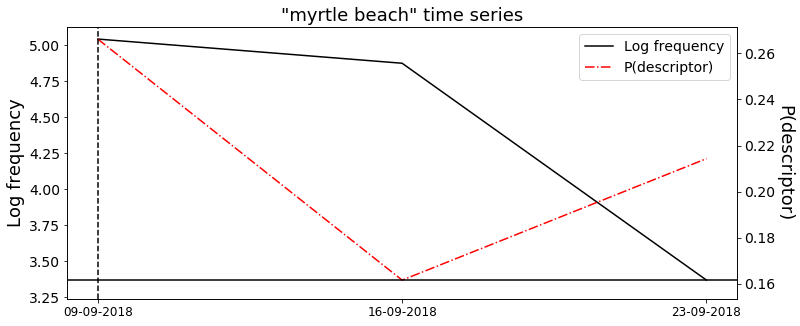

In [70]:
# weekly
data_names_to_plot = ['maria', 'florence']
NEs_to_plot = ['san juan', 'myrtle beach']
plot_data(data_names_to_plot, NEs_to_plot, pre_peak_dates_all, post_peak_dates_all, NE_week_counts_zeros, NE_week_context_zeros, week_data_date_ranges, date_var=week_date_var, days_per_timestep=7)

## Plot context per-week
Let's smooth out some of these blips by plotting P(RE) per-week rather than per-day.

In [12]:
from math import floor
def round_to_day(date, round_day=7):
    day_round = (floor(date.timetuple().tm_yday / round_day)*round_day)
    date_round = datetime.strptime('%d-%d'%(day_round, date.year), '%j-%Y')
    return date_round
week_date_var = 'week_date'
days_per_week = 7
anchor_data = anchor_data.assign(**{
    week_date_var : anchor_data.loc[:, date_var].apply(lambda x: round_to_day(x, days_per_week))
})

In [13]:
# compute weekly date ranges
inter_date_days = 7
data_date_ranges_week = anchor_data.groupby(data_name_var).apply(lambda x: generate_date_range(x.loc[:, week_date_var], inter_date_days=inter_date_days))

In [14]:
context_var = 'anchor'
context_pct_var = '%s_pct'%(context_var)
week_date_var = 'week_date'
NE_context_pcts_week = anchor_data.groupby([NE_var, data_name_var, week_date_var]).apply(lambda x: x.loc[:, context_var].mean()).reset_index().rename(columns={0 : context_pct_var})
NE_context_pcts_date_ranges_week = pd.merge(NE_context_pcts_week, data_date_ranges_week.reset_index().rename(columns={0 : 'data_range'}), on=data_name_var)
NE_context_zeros_week = []
for (NE_i, data_name_i), data_i in NE_context_pcts_date_ranges_week.groupby([NE_var, data_name_var]):
    date_range_N = len(data_i.loc[:, date_range_var].values[0])
    data_i_zeros = pd.concat([pd.Series(np.repeat(data_i.loc[:, NE_var].iloc[0], date_range_N)),
                              pd.Series(np.repeat(data_i.loc[:, data_name_var].iloc[0], date_range_N)),
                              pd.Series(data_i.loc[:, 'data_range'].values[0])], axis=1)
    data_i_zeros.columns = [NE_var, data_name_var, week_date_var]
    data_i = pd.merge(data_i, data_i_zeros, on=[NE_var, data_name_var, week_date_var], how='outer')
    data_i = data_i.drop(date_range_var, axis=1, inplace=False).fillna(0, inplace=False)
    NE_context_zeros_week.append(data_i)
NE_context_zeros_week = pd.concat(NE_context_zeros_week, axis=0) 

Replot all the things.

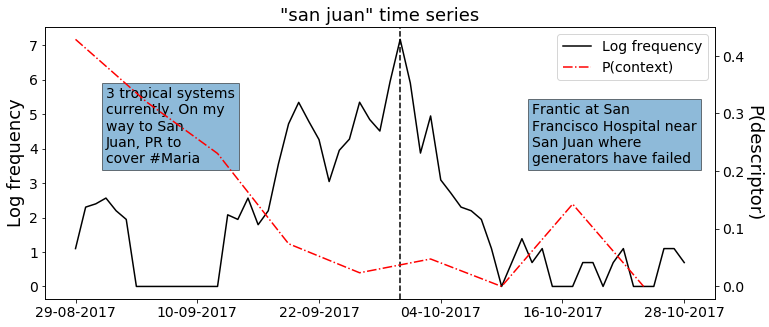

In [15]:
from math import ceil
# word wrap: forces words to split lines
def word_wrap(txt, word_wrap_len=3):
    txt_tokens = txt.split(' ')
    chunks = int(ceil(len(txt_tokens) / word_wrap_len))
    txt_wrap = '\n'.join([' '.join(txt_tokens[(chunk*word_wrap_len):((chunk+1)*word_wrap_len)]) for chunk in range(chunks)])
    return txt_wrap
## set up text values
word_wrap_len = 3
pre_peak_txt = '3 tropical systems currently. On my way to San Juan, PR to cover #Maria'
post_peak_txt = 'Frantic at San Francisco Hospital near San Juan where generators have failed'
# pre_peak_txt = 'Exploring Old\n San Juan in\n Puerto Rico!'
# post_peak_txt = "Hoping to get\n it out Monday\n to a friend's\n family in San Juan."
pre_peak_txt =  word_wrap(pre_peak_txt, word_wrap_len=word_wrap_len)
post_peak_txt =  word_wrap(post_peak_txt, word_wrap_len=word_wrap_len)

# plot params
top_k = 10
x_range_buffer_pct = 0.1
title_font_size = 18
label_font_size = 18
tick_font_size = 14
fig_height = 5
fig_width = 10
tick_date_fmt = '%d-%m-%Y'

## get count/context data
name_i = 'maria'
date_range_i = data_date_ranges.loc[name_i]
x_range = [min(date_range_i), max(date_range_i)]
x_lim_buffer = timedelta(days=((x_range[1]-x_range[0]).days * x_range_buffer_pct))
x_lim = [min(date_range_i)-x_lim_buffer, max(date_range_i)+x_lim_buffer]
counts_i = NE_counts_zeros[NE_counts_zeros.loc[:, data_name_var]==name_i].sort_values(round_date_var, inplace=False, ascending=True)
context_pcts_i = NE_context_zeros_week[NE_context_zeros_week.loc[:, data_name_var]==name_i].sort_values(week_date_var, inplace=False, ascending=True)

NE_j = 'san juan'
## organize time, counts
raw_counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
# mark date with max frequency (for final plot)
max_count_date_j = date_range_i[np.where(raw_counts_j==raw_counts_j.max())[0][0]]
# limit x range to nonzero count dates
min_date_j = date_range_i[min(np.where(raw_counts_j > 0.)[0])]
max_date_j = date_range_i[max(np.where(raw_counts_j > 0.)[0])]
# generate custom date range
date_range_j = [min_date_j + timedelta(days=day_ctr) for day_ctr in range((max_date_j - min_date_j).days + 1)]
plot_date_range_j = [date_k.timestamp() for date_k in date_range_j]
# same custom date range but for weeks
days_per_week = 7
date_range_j_week = [min_date_j + timedelta(days=i*days_per_week) for i in range(int(floor((max_date_j - min_date_j).days / days_per_week)) + 1)]
plot_date_range_j_week = [date_k.timestamp() for date_k in date_range_j_week]
# restrict counts to valid dates
# raw counts
counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
# log counts
counts_i_valid_dates = counts_i[(counts_i.loc[:, round_date_var] >= min_date_j) & 
                                (counts_i.loc[:, round_date_var] <= max_date_j)]
context_pcts_i_valid_dates = context_pcts_i[(context_pcts_i.loc[:, week_date_var] >= min_date_j) & 
                                            (context_pcts_i.loc[:, week_date_var] <= max_date_j)]
raw_counts_j_valid = counts_i_valid_dates[counts_i_valid_dates.loc[:, NE_var]==NE_j].loc[:, count_var]
counts_j = np.log(raw_counts_j_valid+1)
context_pcts_j = context_pcts_i_valid_dates[context_pcts_i_valid_dates.loc[:, NE_var]==NE_j].loc[:, context_pct_var]

## plot
fig_height = 5
fig_width = 12
f, ax1 = plt.subplots(figsize=(fig_width, fig_height))
ax2 = ax1.twinx()
# set axis tick sizes
ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
# log counts
ax1_line = ax1.plot(plot_date_range_j, counts_j, color='k', label='Log frequency')
ax2_line = ax2.plot(plot_date_range_j_week, context_pcts_j, color='r', linestyle='-.', label='P(context)')
# vertical line for max frequency
# ax1.vlines(x=[max_count_date_j, max_count_date_j], ymin=counts_j.min(), ymax=counts_j.max(), linestyle='--', color='k')
ax1.set_ylabel('Log frequency', fontsize=label_font_size)
ax2.set_ylabel('P(descriptor)', rotation=270, labelpad=18, fontsize=label_font_size)
plt.title('"%s" time series'%(NE_j), fontsize=title_font_size)
# multiple axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1+lines2, labels1+labels2, fontsize=tick_font_size)
# set x-ticks so they actually fit ;_;
x_ticks = plot_date_range_j[::12]
date_x_ticks = date_range_j[::12]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([date_k.strftime(tick_date_fmt) for date_k in date_x_ticks])

## add text
date_range_j_count = len(date_range_j)
pre_text_x = plot_date_range_j[int(date_range_j_count * (1/16.))]
post_text_x = plot_date_range_j[int(date_range_j_count * (3/4.))]
text_y = (counts_j.max() - counts_j.min()) / 2.
ax1.text(pre_text_x, text_y, pre_peak_txt, bbox={'alpha':0.5}, fontsize=tick_font_size)
ax1.text(post_text_x, text_y, post_peak_txt, bbox={'alpha':0.5}, fontsize=tick_font_size)

## vertical line for collective attention peak
ax1.axvline(x=max_count_date_j.timestamp(), linestyle='--', color='k')
plt.show()

Did not noticeably improve! Maybe too smooth.

### Plot smoothed frequency and context over time

Smooth frequency and context time series, then replot.

processing florence data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


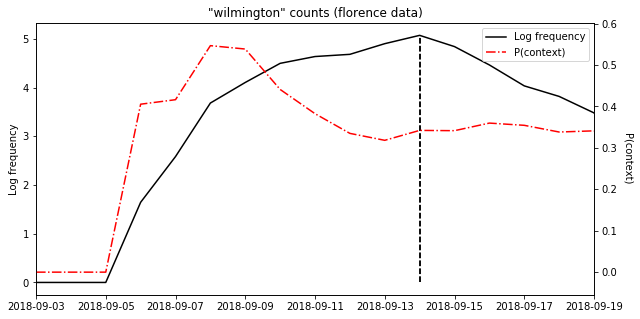

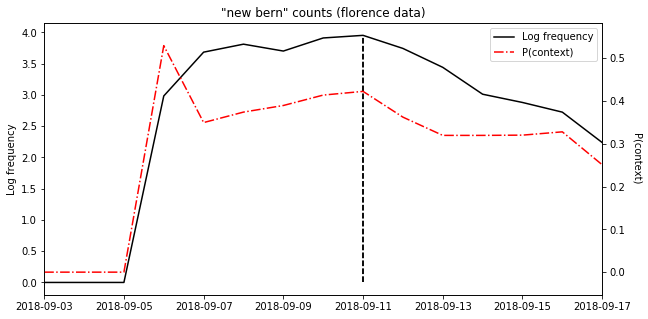

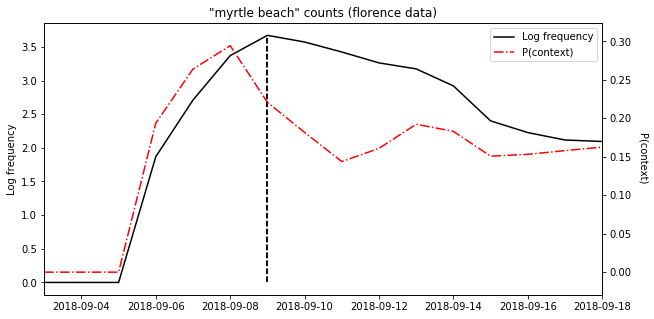

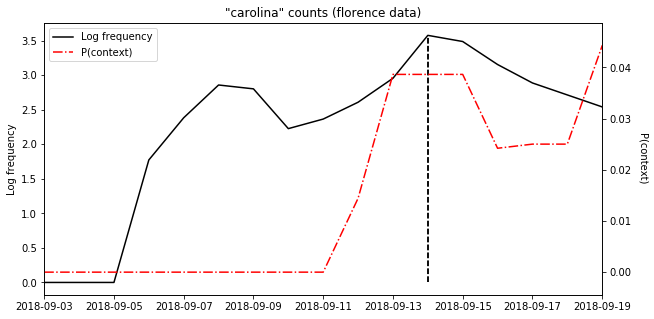

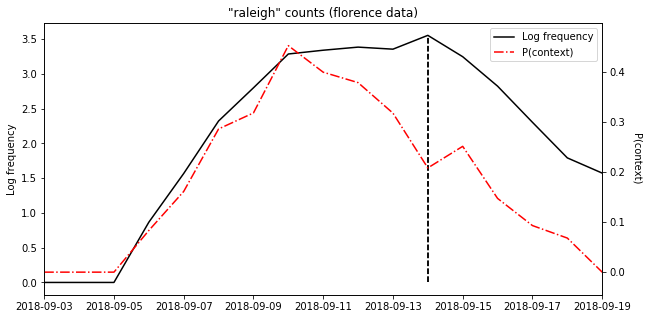

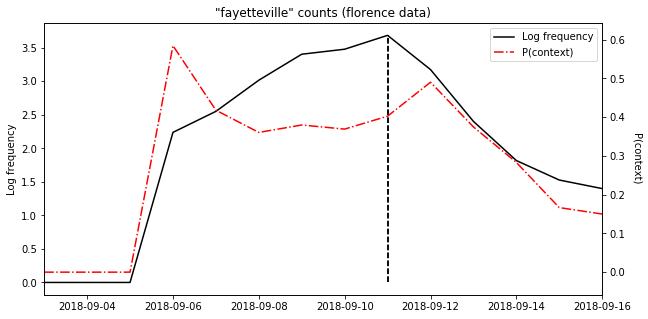

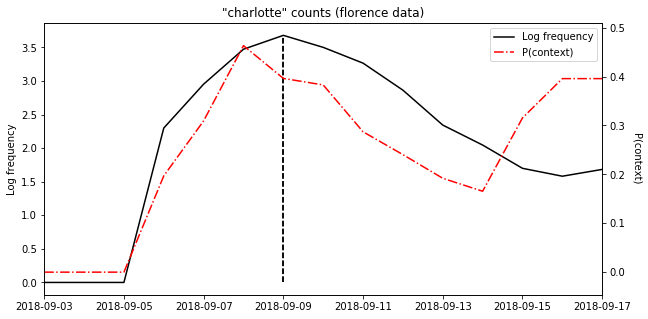

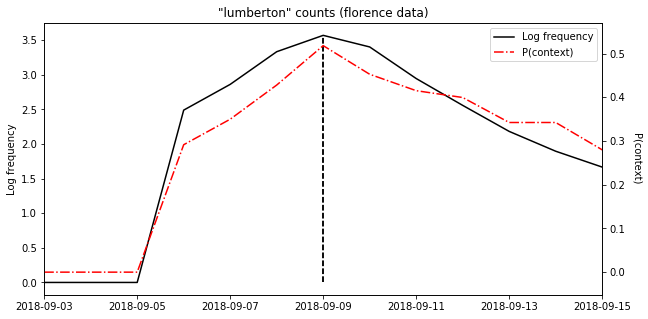

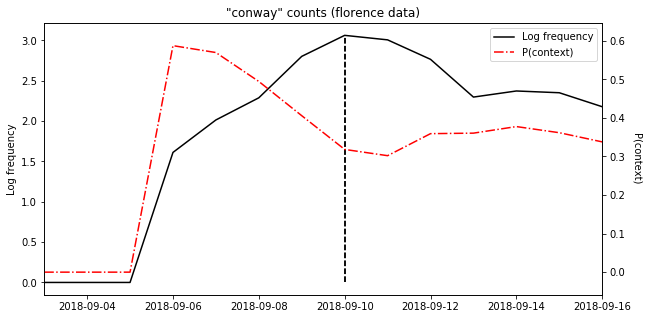

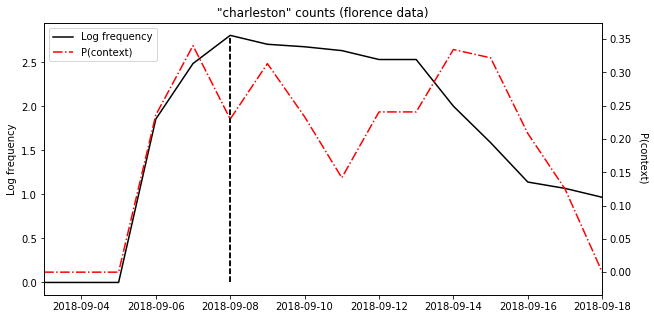

processing harvey data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


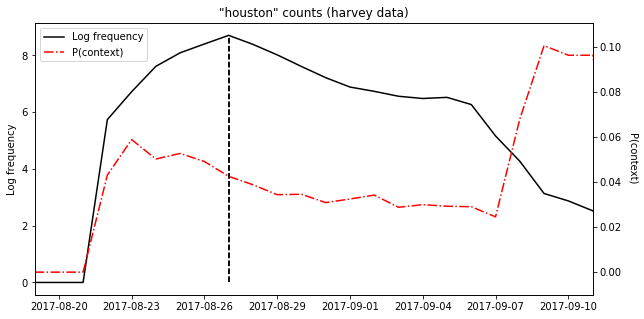

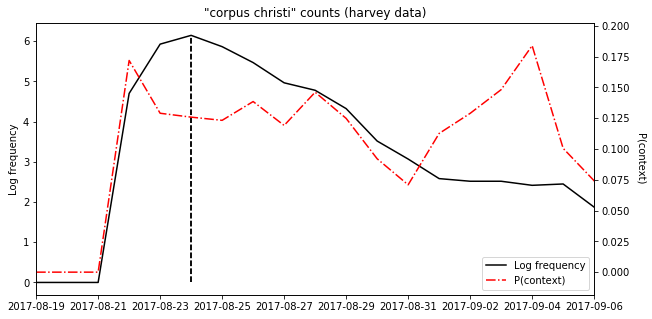

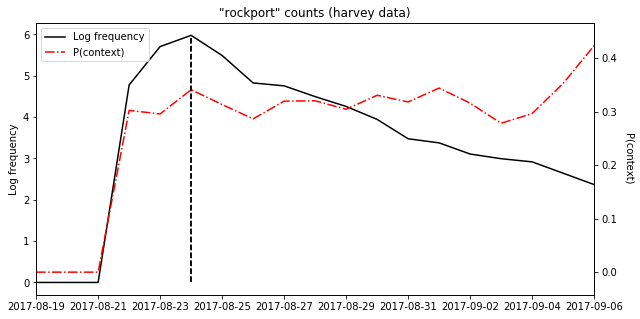

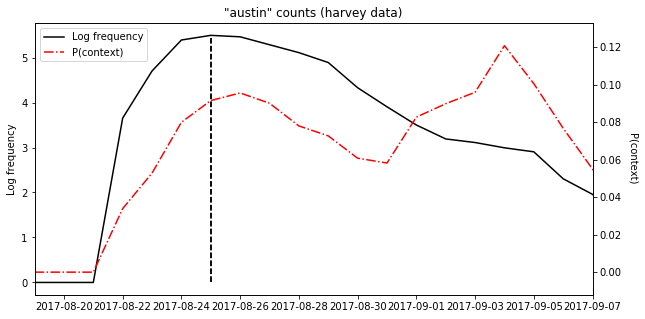

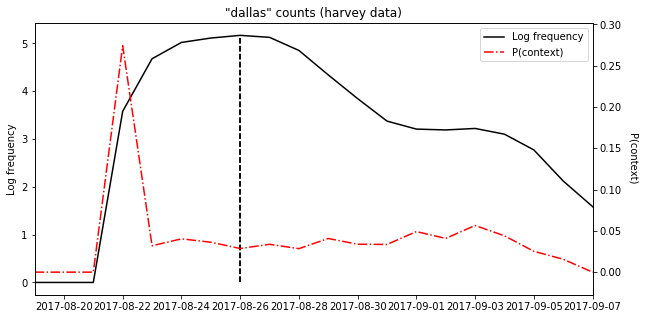

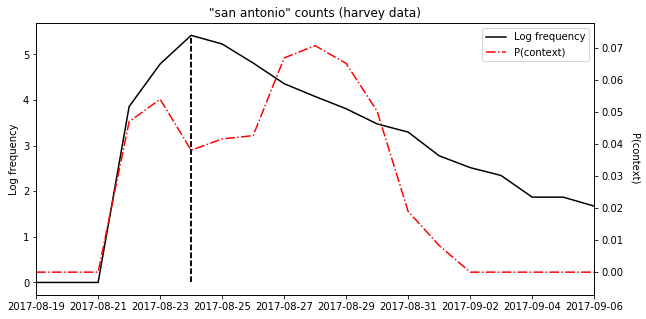

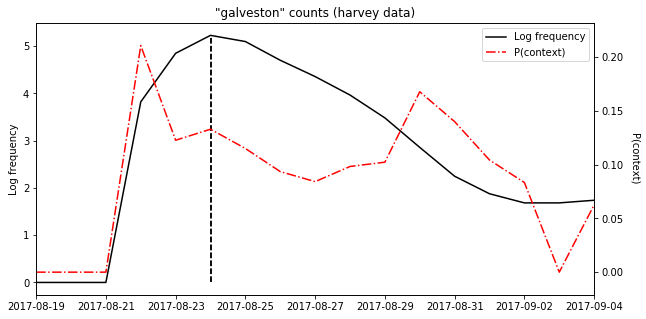

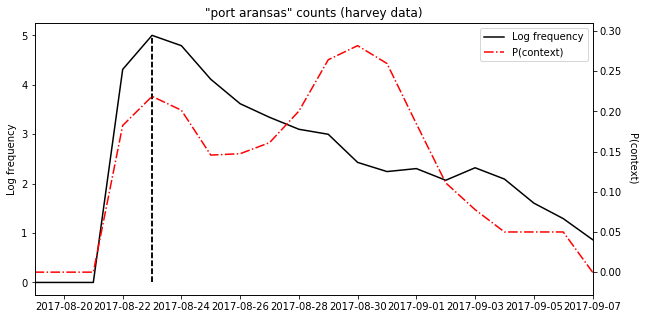

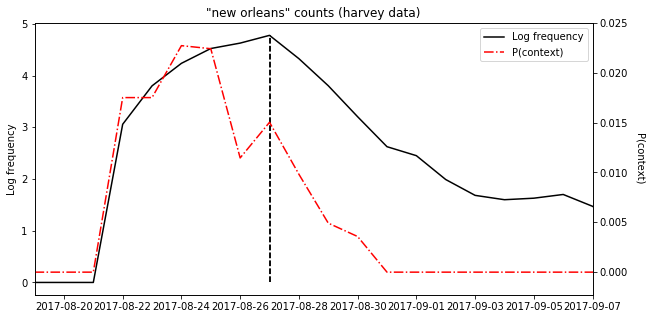

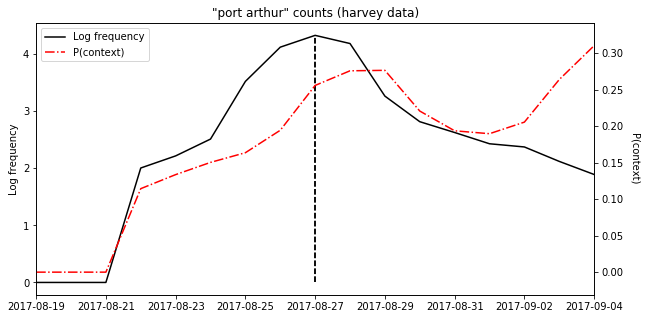

processing irma data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


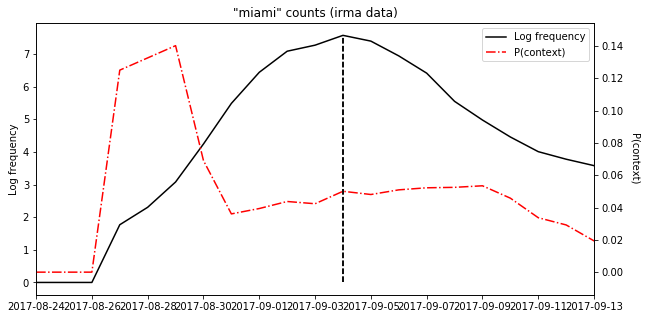

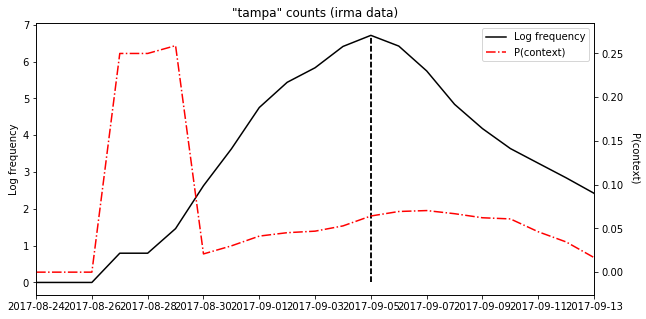

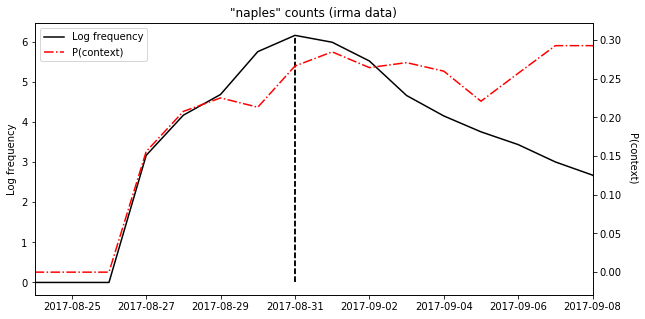

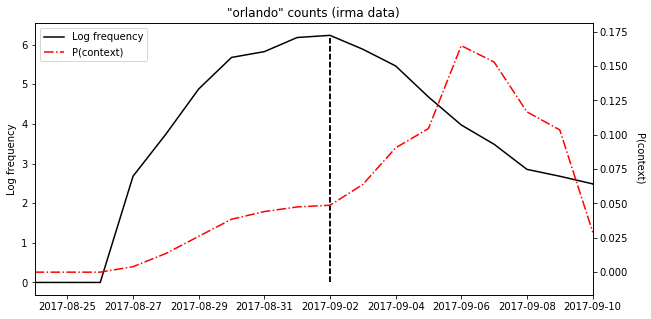

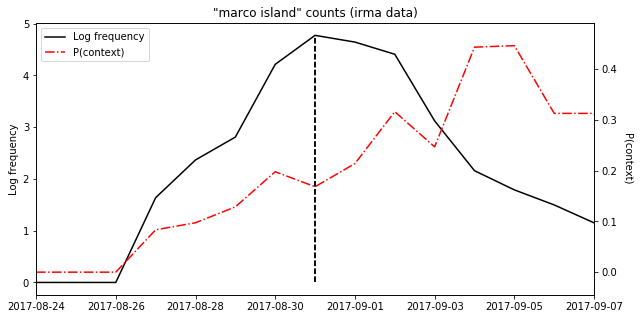

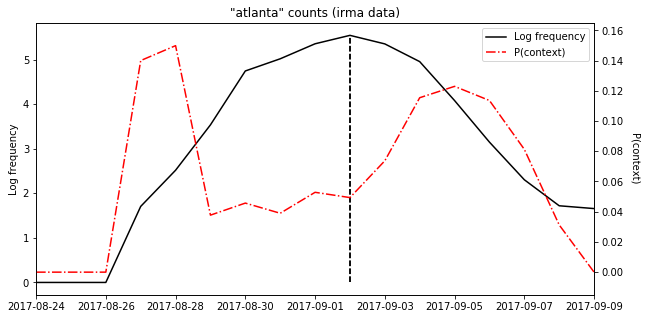

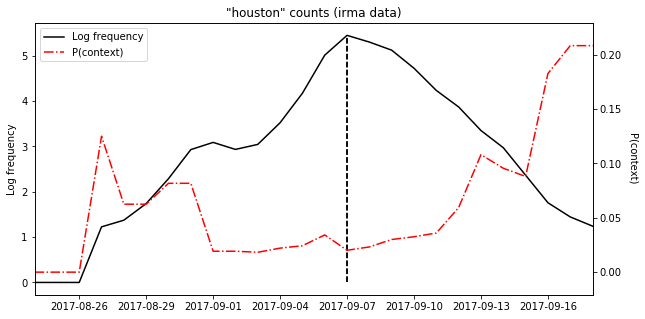

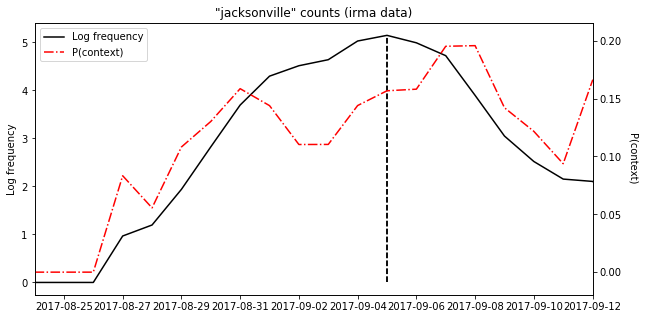

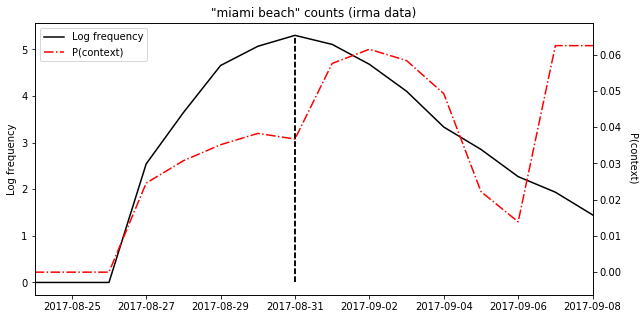

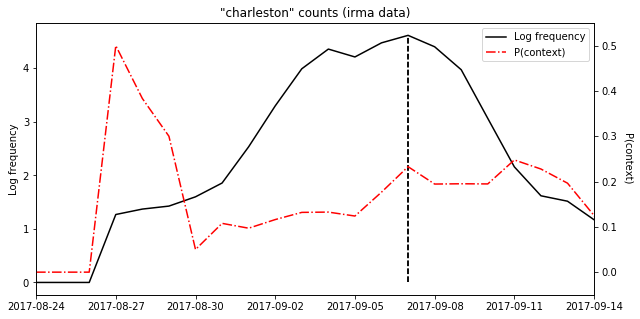

processing maria data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


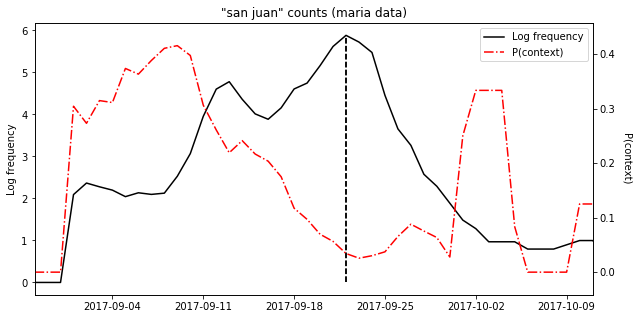

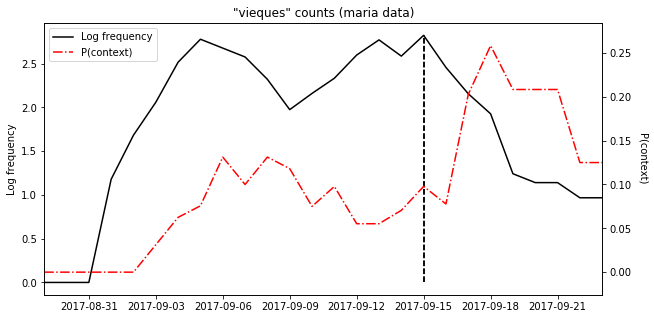

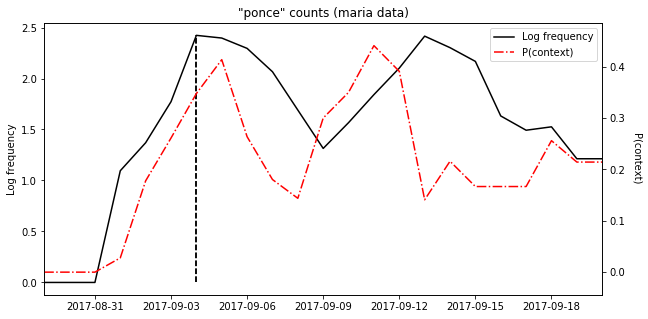

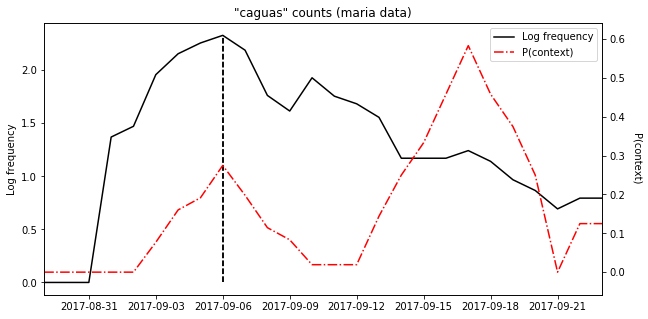

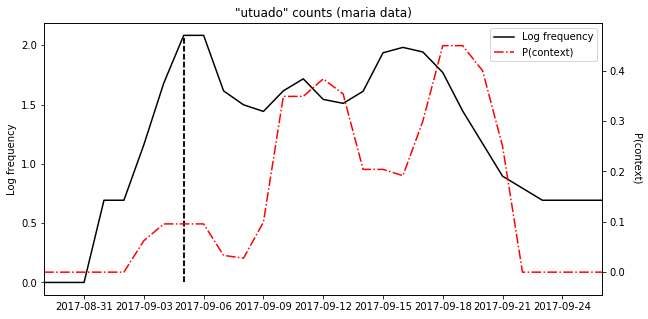

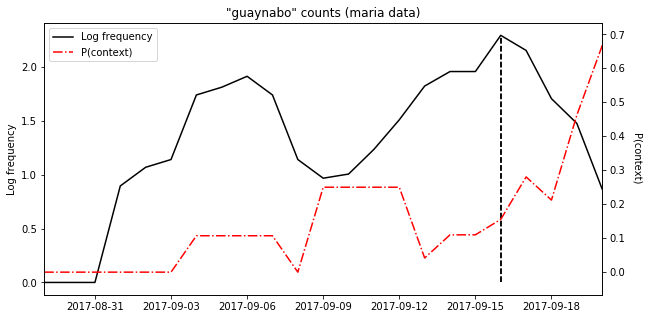

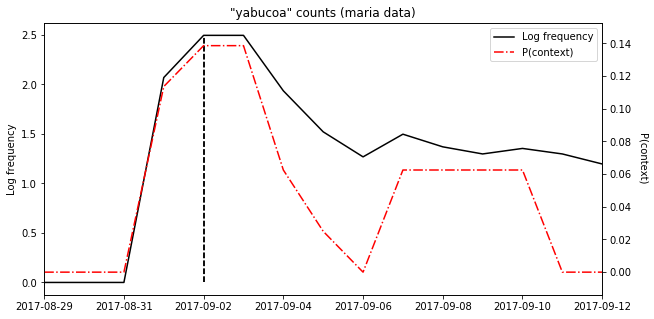

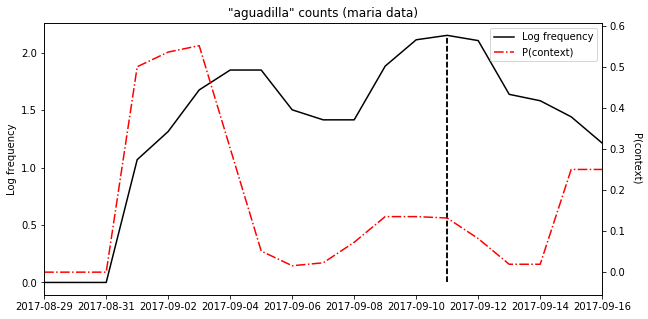

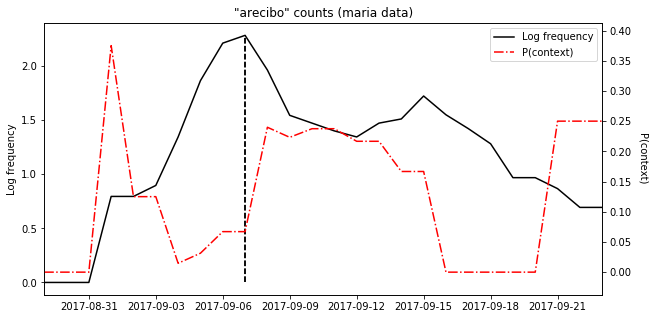

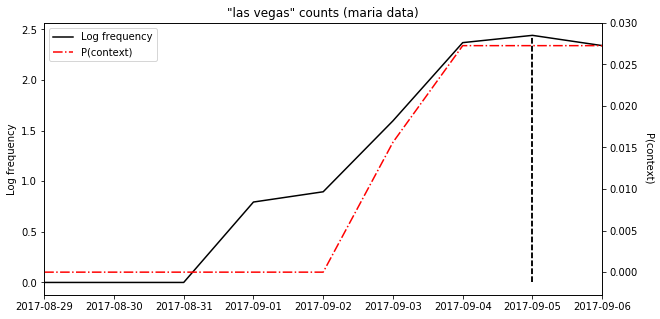

processing michael data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


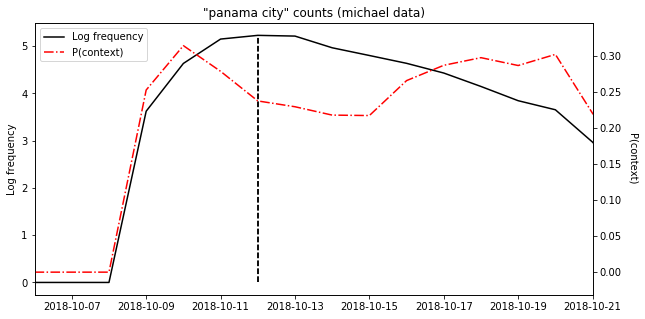

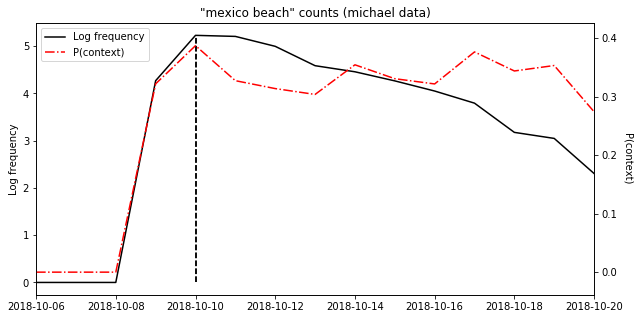

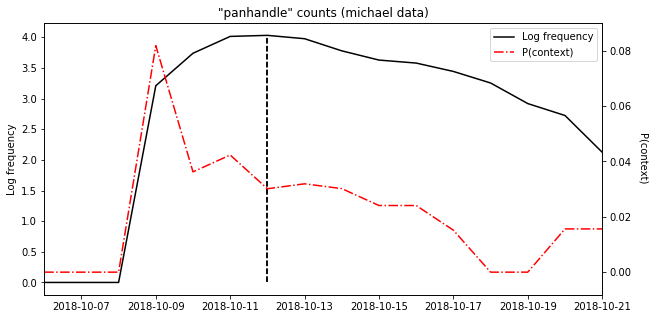

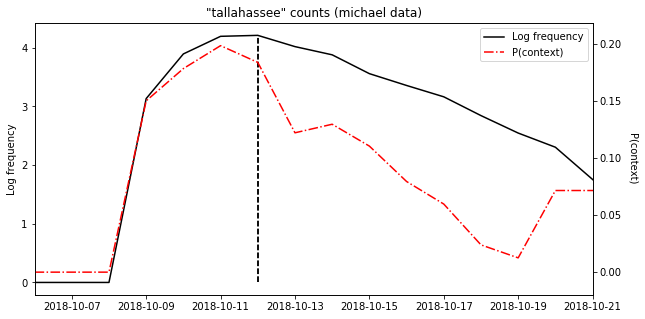

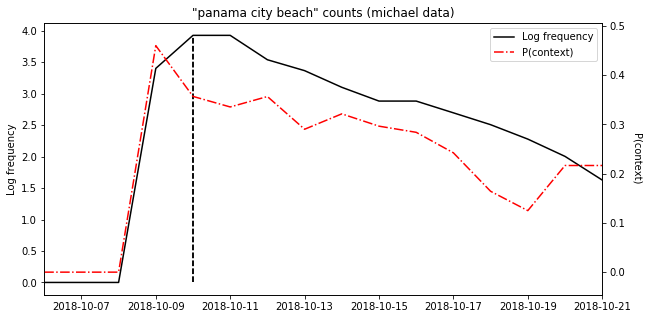

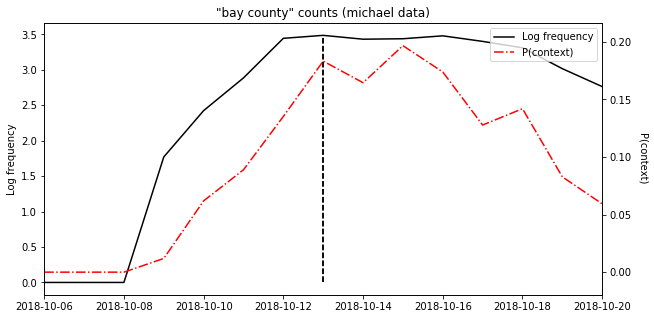

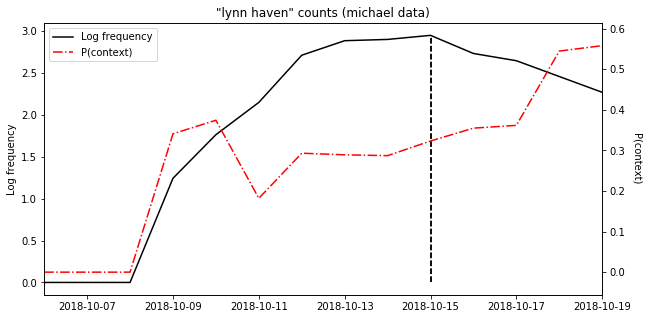

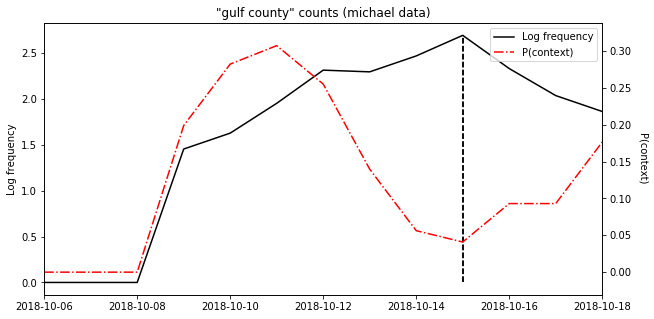

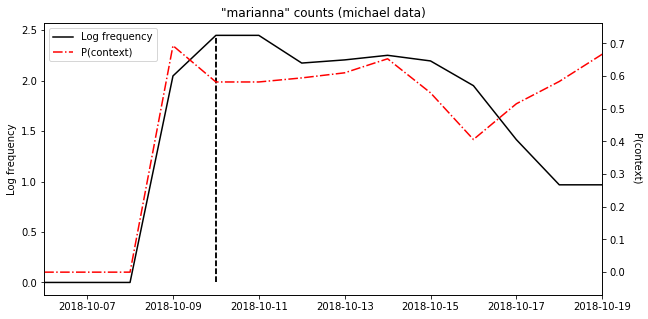

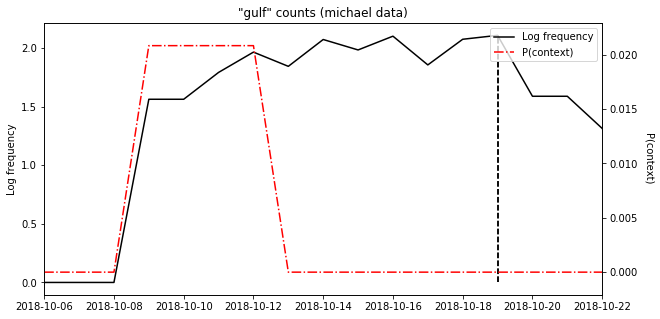

In [26]:
top_k = 10
x_range_buffer_pct = 0.1
smooth_window = 4
for name_i, data_i in NE_counts_per_time.groupby(data_name_var):
    print('processing %s data'%(name_i))
    date_range_i = data_date_ranges.loc[name_i]
    x_range = [min(date_range_i), max(date_range_i)]
    x_lim_buffer = timedelta(days=((x_range[1]-x_range[0]).days * x_range_buffer_pct))
    x_lim = [min(date_range_i)-x_lim_buffer, max(date_range_i)+x_lim_buffer]
    counts_i = NE_counts_zeros[NE_counts_zeros.loc[:, data_name_var]==name_i]
    context_pcts_i = NE_context_zeros[NE_context_zeros.loc[:, data_name_var]==name_i]
    data_i.sort_values(count_mean_var, inplace=True, ascending=False)
    for j in range(top_k):
        NE_j = data_i.iloc[j].loc[NE_var]
        
        # compute counts/context
        # raw counts
#         counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
        # log counts
        raw_counts_j = counts_i[counts_i.loc[:, NE_var]==NE_j].loc[:, count_var]
        counts_j = np.log(raw_counts_j+1)
        context_pcts_j = context_pcts_i[context_pcts_i.loc[:, NE_var]==NE_j].loc[:, context_pct_var]
        # smooth counts
        counts_j = counts_j.rolling(smooth_window).mean().fillna(0.)
        context_pcts_j = context_pcts_j.rolling(smooth_window).mean().fillna(0.)
        
        # mark timestep with max frequency
        max_count_date_j = date_range_i[np.where(counts_j==counts_j.max())[0][0]]
        # limit x range to nonzero count dates
        min_date_j = date_range_i[min(np.where(raw_counts_j > 0.)[0])]
        max_date_j = date_range_i[max(np.where(raw_counts_j > 0.)[0])]
        x_lim = [min_date_j, max_date_j]
        
        # plot
        f, ax1 = plt.subplots(figsize=(10,5))
        ax2 = ax1.twinx()
        # raw counts
#         ax1.plot(date_range_i, counts_j, color='b')
        # log counts
        ax1_line = ax1.plot(date_range_i, counts_j, color='k', label='Log frequency')
        ax2_line = ax2.plot(date_range_i, context_pcts_j, color='r', linestyle='-.', label='P(context)')
        # vertical line for max frequency
        ax1.vlines(x=[max_count_date_j, max_count_date_j], ymin=counts_j.min(), ymax=counts_j.max(), linestyle='--', color='k')
        ax1.set_ylabel('Log frequency')
        ax2.set_ylabel('P(context)', rotation=270, labelpad=16)
#         ax1.set_ylim(counts_j.min() - ((counts_j.max() - counts_j.min())*0.1), 
#                      counts_j.max() + ((counts_j.max() - counts_j.min())*0.1))
        ax2.set_ylim(context_pcts_j.min()-((context_pcts_j.max()-context_pcts_j.min())*0.1), 
                     context_pcts_j.max()+((context_pcts_j.max()-context_pcts_j.min())*0.1))
        plt.title('"%s" counts (%s data)'%(NE_j, name_i))
        plt.xlim(*x_lim)
        # add legend
        # single axis
#         plt.legend(loc='upper right')
        # multiple axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1+lines2, labels1+labels2)
        plt.show()

### Old code

## Load data

In [89]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from models.predict_descriptor_in_twitter import load_clean_data
import dateutil
data_file = '../../data/mined_tweets/combined_tweet_tag_data_NE_flat.gz'
combined_data_full = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_all.gz', sep='\t', index_col=False, compression='gzip', converters={'date': dateutil.parser.parse})
combined_data = load_clean_data(data_file, top_k_NE_min=1)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [90]:
print(combined_data_full.shape[0])
print(combined_data.shape[0])

2339173
137779


In [93]:
import dateutil
from models.predict_descriptor_in_twitter import compute_days
combined_data_full = combined_data_full.assign(**{'date' : combined_data_full.loc[:, 'date'].apply(dateutil.parser.parse)})
combined_data_full = compute_days(combined_data_full)

## Daily frequency

In [108]:
from datetime import datetime, timedelta
data_name_i = 'maria'
time_var = 'date_day'
group_var = 'data_name_fixed'
id_var = 'id'
combined_data_i = combined_data[combined_data.loc[:, group_var]==data_name_i]
combined_data_full_i = combined_data_full[combined_data_full.loc[:, group_var]==data_name_i]
## remove all data from before formation date
combined_data_i = combined_data_i[combined_data_i.loc[:, time_var] >= combined_data_i.loc[:, 'form'].iloc[0]]
combined_data_full_i = combined_data_full_i[combined_data_full_i.loc[:, time_var] >= combined_data_i.loc[:, 'form'].iloc[0]]
data_freq_i = combined_data_full_i.groupby(time_var).apply(lambda x: x.loc[:, 'id'].nunique())

In [109]:
combined_data_full_i.shape[0]

380439

In [110]:
print(data_freq_i)

date_day
2017-09-16     2571
2017-09-17     4648
2017-09-18    12362
2017-09-19    10925
2017-09-20    14334
2017-09-21    15435
2017-09-22    11818
2017-09-23     3918
2017-09-24     7234
2017-09-25    19250
2017-09-26    32537
2017-09-27    24340
2017-09-28    22771
2017-09-29    24558
2017-09-30    42981
2017-10-01    21122
2017-10-02     5809
2017-10-03    17869
2017-10-04     2957
2017-10-05     2092
2017-10-06     1985
2017-10-07     1288
2017-10-08     1108
2017-10-09      307
2017-10-10      283
2017-10-11      247
2017-10-12      473
2017-10-13      323
2017-10-14      230
2017-10-15      266
2017-10-16      313
2017-10-17      473
2017-10-18      391
2017-10-19      203
2017-10-20      209
2017-10-21      146
2017-10-22      145
2017-10-23      115
2017-10-24      137
2017-10-25      135
2017-10-26      164
2017-10-27      127
2017-10-28      116
2017-10-29      106
2017-10-30      114
2017-10-31       42
dtype: int64


[Timestamp('2017-09-16 00:00:00'), Timestamp('2017-09-19 00:00:00'), Timestamp('2017-10-02 00:00:00')]


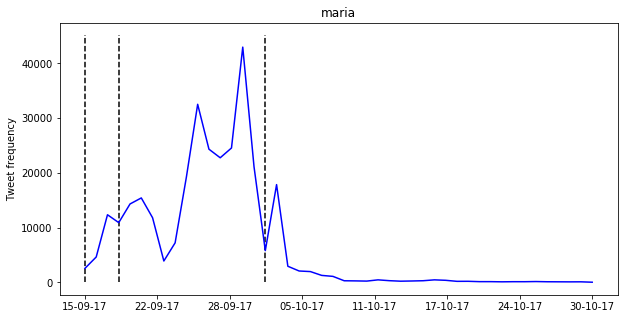

In [111]:
from math import floor
period_names = combined_data_i.loc[:, 'time_period_type'].unique()
X_tick_count = 8
X = [x.timestamp() for x in data_freq_i.index]
X_ticks = np.linspace(X[0], X[-1], X_tick_count)
date_fmt = '%d-%m-%y'
X_ticks_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in X_ticks]
event_times = [combined_data_i.loc[:, x].iloc[0] for x in period_names]
X_event_times = [x.timestamp() for x in event_times]
print(event_times)
plt.figure(figsize=(10,5))
plt.plot(X, data_freq_i.values, color='b', linestyle='-')
## add event lines
y_min, y_max = (0, data_freq_i.max()*1.05)
plt.vlines(X_event_times, y_min, y_max, color='k', linestyle='--')
plt.xticks(X_ticks, X_ticks_str)
plt.ylabel('Tweet frequency')
plt.title(data_name_i)
plt.show()

What does the proportion of anchoring information look like for some example entities over time?

3398 samples with entity san_juan
time_period_type
form           0.340426
landfall       0.069044
dissipation    0.060150
dtype: float64
214 samples with entity vieques
time_period_type
form           0.000000
landfall       0.110465
dissipation    0.105263
dtype: float64
138 samples with entity ponce
time_period_type
form           0.100000
landfall       0.223301
dissipation    0.320000
dtype: float64
110 samples with entity caguas
time_period_type
form           0.000000
landfall       0.170732
dissipation    0.437500
dtype: float64
108 samples with entity utuado
time_period_type
form           0.000000
landfall       0.176471
dissipation    0.243243
dtype: float64
105 samples with entity guaynabo
time_period_type
form           0.000000
landfall       0.179104
dissipation    0.218750
dtype: float64
103 samples with entity yabucoa
time_period_type
form           0.000000
landfall       0.184783
dissipation    0.000000
dtype: float64
94 samples with entity aguadilla
time_period_type

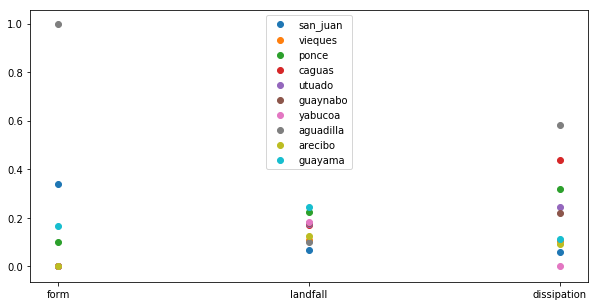

In [73]:
time_period_var = 'time_period_type'
time_var = 'date'
NE_col = 'NE_fixed'
# dep_var = 'max_population_anchor'
dep_var = 'has_descriptor'
time_periods = combined_data_i.groupby(time_period_var).apply(lambda x: x.loc[:, time_var].min()).sort_values().index
X = np.arange(len(time_periods))
entity_top_k = 10
top_k_entities = combined_data_i.loc[:, NE_col].value_counts()[:entity_top_k].index.tolist()
plt.figure(figsize=(10,5))
for entity_j in top_k_entities:
#     entity_j = 'san_juan' # san_juan vieques ponce caguas utuado
    # display(combined_data_i.loc[:, NE_col].value_counts()[:5])
    combined_data_i_j = combined_data_i[combined_data_i.loc[:, NE_col]==entity_j]
    # display(combined_data_i_j.head())
    print('%d samples with entity %s'%(combined_data_i_j.shape[0], entity_j))
    anchor_probs_time_i = combined_data_i_j.groupby(time_period_var).apply(lambda x: x.loc[:, dep_var].sum() / x.shape[0])
    anchor_probs_time_i = anchor_probs_time_i.loc[time_periods]
    print(anchor_probs_time_i)
    plt.scatter(X, anchor_probs_time_i, label=entity_j)
plt.legend(loc='upper center')
plt.xticks(X, time_periods)
plt.show()

Same thing but with multiple sub-points per time period (`form_1`, etc.).

In [80]:
N_time_period_bins = 2
combined_data_time_i= []
time_period_var = 'time_period_type'
time_period_bin_var = '%s_bin'%(time_period_var)
time_var = 'date_day'
for time_period_j, data_j in combined_data_i.groupby(time_period_var):
    timestamps_j = data_j.loc[:, time_var].apply(lambda x: x.timestamp())
    time_bins_j = np.linspace(timestamps_j.min(), timestamps_j.max(), N_time_period_bins+1)[:-1]
    time_bins_j = np.digitize(timestamps_j, bins=time_bins_j, right=False)
    time_bins_str_j = ['%s_%s'%(time_period_j, x) for x in time_bins_j]
    data_j = data_j.assign(**{time_period_bin_var : time_bins_str_j})
    combined_data_time_i.append(data_j)
combined_data_time_i = pd.concat(combined_data_time_i, axis=0)
print(combined_data_time_i.loc[:, time_period_bin_var].value_counts())

landfall_2       2984
landfall_1       1220
dissipation_1     445
form_2            110
dissipation_2      29
form_1             17
Name: time_period_type_bin, dtype: int64


## Combined plot

Combined plot! With just one NE because otherwise it's hard to read.

['form', 'landfall', 'dissipation']


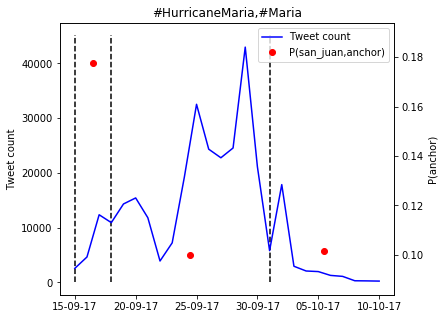

In [154]:
## cutoff long tail of frequency?
freq_end_idx = -20
data_freq_i_cutoff = data_freq_i.iloc[:freq_end_idx]
plt_title = '#HurricaneMaria,#Maria'

fig = plt.figure(figsize=(6, 5))
freq_plot = fig.add_subplot(111)

anchor_plot = freq_plot.twinx()

## frequency
from math import floor
time_period_var = 'time_period_type'
period_names = combined_data_i.loc[:, time_period_var].unique()
period_names = sorted(period_names, key=lambda x: combined_data_i.loc[:, x].iloc[0])
print(period_names)
X_tick_count = 6
X = [x.timestamp() for x in data_freq_i_cutoff.index]
X_ticks = np.linspace(X[0], X[-1], X_tick_count)
date_fmt = '%d-%m-%y'
X_ticks_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in X_ticks]
event_times = [combined_data_i.loc[:, x].iloc[0] for x in period_names]
X_event_times = [x.timestamp() for x in event_times]
freq_fig, = freq_plot.plot(X, data_freq_i_cutoff.values, color='b', linestyle='-', label='Tweet count')
## add event lines
y_min, y_max = (0, data_freq_i_cutoff.max()*1.05)
freq_plot.vlines(X_event_times, y_min, y_max, color='k', linestyle='--')
freq_plot.set_xticks(X_ticks)
freq_plot.set_xticklabels(X_ticks_str)
freq_plot.set_ylabel('Tweet count')

## anchor
entity_j = 'san_juan'
dep_var = 'max_population_anchor'
entity_j_pcts = combined_data_i.groupby(time_period_var).apply(lambda x: x[x.loc[:, 'NE_fixed']==entity_j].loc[:, dep_var].sum() / x[x.loc[:, 'NE_fixed']==entity_j].loc[:, dep_var].shape[0])
entity_j_pcts = entity_j_pcts.loc[period_names]
# x-position = halfway between every event
all_event_times = event_times + [datetime.fromtimestamp(max(X))]
X_anchor = [np.mean([all_event_times[t].timestamp(), all_event_times[t+1].timestamp()]) for t in range(len(all_event_times)-1)]
# print(X_anchor)
## scatter plot 
anchor_fig = anchor_plot.scatter(X_anchor, entity_j_pcts.values, marker='o', color='r', label='P(%s,anchor)'%(entity_j))
anchor_plot.set_ylabel('P(anchor)')


## joint plot data
plt.title(plt_title)
plt.legend(handles=[freq_fig, anchor_fig], loc='best')
plt.show()